<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Segment customers of a website - P5</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">| Analysis notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

## df_analysis
import io
import gc
import timeit
import math
from collections import Counter
from math import prod
import scipy.stats as stats

## Scikit Learn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

## Own specific functions 
# from functions import *

%matplotlib inline
sns.set_theme(style="darkgrid")

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [354]:
def df_analysis(df, name_df, *args, **kwargs):
    """
    Method used to analyze on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        
        *args, **kwargs:
        -----------------
            columns (list): Dataframe keys in list format
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    columns = kwargs.get("columns", None)
    type_analysis = kwargs.get("type_analysis", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        if columns is not None:
            print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
            
        if type_analysis == "summarized":
            print("\n")
        
        if type_analysis is None or type_analysis != "summarized":
            pd.set_option("display.max_rows", None) # show full of showing rows
            pd.set_option("display.max_columns", None) # show full of showing cols
            pd.set_option("display.max_colwidth", None) # show full width of showing cols
            pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    
            
            if type_analysis is None or type_analysis != "complete":
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            elif type_analysis == "complete" and (df.select_dtypes(["int64"]).shape[1] > 0 or df.select_dtypes(["float64"]).shape[1] > 0):
                df_resume["unique"] = list(df.nunique())
                df_desc = pd.DataFrame(df.describe().T).reset_index()
                df_desc = df_desc.rename(columns={"index": "name"})
                df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
                df_resume = df_resume[ORDERING_COMPLETE]
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            
            display(df_resume.sort_values("records", ascending=False))
            
            pd.reset_option("display.max_rows") # reset max of showing rows
            pd.reset_option("display.max_columns") # reset max of showing cols
            pd.reset_option("display.max_colwidth") # reset width of showing cols
            pd.reset_option("display.float_format") # reset show full content in cell
            
        # deleting dataframe to free memory
        if type_analysis == "complete":
            
            if df.select_dtypes(["int64"]).shape[1] > 0 or df.select_dtypes(["float64"]).shape[1] > 0:
                del [[df_resume, df_desc]]
            else:
                del [[df_resume]]
            
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()
            

def normality_test(df):
    """
    Method used to make the normality test.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    list_test = {
        "Shapiro-Wilk":stats.shapiro, "D’Agostino’s K^2":stats.normaltest,
        "Kolmogorov-Smirnov":stats.kstest
    }
    
    
    alpha = 0.05
    fail_to_reject_H = "Sample looks Gaussian (fail to reject H0)"
    reject_H = "Sample does not look Gaussian (reject H0)"
    
    variable, test_name, result, hypothesis = [[] for i in range(4)]
    
    for key, value in list_test.items():
    
        for col in df.columns:
            
            if df[col].dtypes == "float64" or df[col].dtypes == "int64":
                variable.append(col)
                test_name.append(key)
                
                if key == "Kolmogorov-Smirnov":
                    stat, p_value = value(df[col], cdf="norm")
                else:
                    stat, p_value = value(df[col])
                    
                result.append("Statistics=%.3f, p-value=%.3f" % (stat, p_value))
                hypothesis.append(fail_to_reject_H.translate(SUB)) if p_value > alpha else hypothesis.append(reject_H.translate(SUB))
                
    df_normality_test = pd.DataFrame({
                            "variable": variable,
                            "normality test": test_name, 
                            "result": result,
                            "hypothesis": hypothesis})
    
    display(df_normality_test)
    

def highlight_max(data, color="yellow"):
    """ 
    highlight the maximum in a Series or DataFrame
    
    Parameters:
    -----------------  
        data (pandas.DataFrame): Dataset to analyze
        color (str) : color to highlight into the dataset
        
    Returns:
    -----------------
        data (pandas.DataFrame): Dataset analyzed
   """  
    
    #attr = 'background-color: {}'.format(color) + 'color: black'
    attr = "background-color: yellow; color: black"
    
    #remove % and cast to float
    data = data.replace("%","", regex=True).astype(float)
    
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else "" for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        
        return pd.DataFrame(np.where(is_max, attr, ""),
                            index=data.index, columns=data.columns)

      
def df_imputations(training_df, test_df, imputation, scaler):
    """
    Method used for making imputations on missing-values

    Parameters:
    -----------------
        training_df : pandas.DataFrame
        Training dataset.
        
        test_df : pandas.DataFrame
        Dataset to impute.
        
        imputation : list
        Imputation's method ["SimpleImputer", "KNNImputer", "IterativeImputer"].
        
        scaler : obj
        Object StandardScaler().
        
    Returns:
    -----------------
        df_to_impute : pandas.DataFrame
        Dataset imputed.
        
    """
    
    # Initializing the imputer
    if imputation == "SimpleImputer":
        impute = SimpleImputer(missing_values=np.nan, strategy="mean")
    elif imputation == "KNNImputer":
        impute = KNNImputer()
    elif imputation == "IterativeImputer":
        impute = IterativeImputer(estimator=BayesianRidge(), 
                                  imputation_order="ascending", 
                                  initial_strategy="mean")
        
    # Making the imputation fit() in train set
    impute.fit(training_df)
    
    # Making the imputation transform() in test set
    temp_imputed = impute.transform(test_df)
    
    # Rebuilding the dataset as original 
    df_imputed = pd.DataFrame(temp_imputed, index=test_df.index, columns=test_df.columns)
    
    # Desnormalizing and formatting data to DataFrame
    df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), index=df_imputed.index, columns=df_imputed.columns)
    
    return df_imputed
    
    
def RFM_analysis(df, customer_id, recency, frequency, value, satisfaction):
    """
    Method to make RFM Analysis stand for recency, frequency, and monetary value.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        customer_id (str): Feature with customer identifier
        recency (str): Feature with recency information
        frequency (str): Feature with frequency information
        value (str): Feature with monetary value information
        satisfaction (str): Feature with customer score

    Returns:
    -----------------
        df_RFM (pandas.DataFrame): Dataset with RFM segmentation
    """
    
    max_day = df[recency].max()
    
    df_RFM = df.groupby([customer_id]).agg({
        recency : lambda x: (max_day - x.max()).days,
        frequency : "count",
        value: "sum",
        satisfaction: "mean"
    })
    
    df_RFM.columns = ["recency", "frequency", "monetary", "satisfaction"]
    df_RFM.reset_index(inplace=True)
    
    return df_RFM  

    
def quintile_score(X, quantiles, rfm_feature):
    """
    Method used to attribute score (between 1 and 5) based on positions into quantiles.
    The bigger the X, the bigger the score

    Parameters:
    -----------------
        X (int): Feature value to attribute score
        quantiles (pandas.DataFrame): Dataset with values at the given quantile over RFM axis
        rfm_feature(str): Feature identifier

    Returns:
    -----------------
        score (int)
    """    
    
    if X <= quantiles[rfm_feature][.2]:
        return 1
    elif X <= quantiles[rfm_feature][.4]:
        return 2
    elif X <= quantiles[rfm_feature][.6]:
        return 3
    elif X <= quantiles[rfm_feature][.8]:
        return 4
    else:
        return 5

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

In [3]:
df_customers = pd.read_csv(r"datasets\olist_customers_dataset.csv")
df_products = pd.read_csv(r"datasets\olist_products_dataset.csv")
df_product_category_name_translations = pd.read_csv(r"datasets\product_category_name_translation.csv")
df_orders = pd.read_csv(r"datasets\olist_orders_dataset.csv")
df_order_payments = pd.read_csv(r"datasets\olist_order_payments_dataset.csv")
df_order_reviews = pd.read_csv(r"datasets\olist_order_reviews_dataset.csv")
df_order_items = pd.read_csv(r"datasets\olist_order_items_dataset.csv")
df_sellers = pd.read_csv(r"datasets\olist_sellers_dataset.csv")
df_geolocations = pd.read_csv(r"datasets\olist_geolocation_dataset.csv")

df_brasil_regions = pd.read_csv(r"datasets\brasil_regions.csv")

<div class="alert alert-block alert-info">
    <p>The following description of each dataset, is organized in order of importance</p>
    <ul>
       <li><b>Customer</b> dataset <b>"olist_customers_dataset.csv"</b>.<br>
           Basic customer information
        </li>
       <li><b>Order</b> dataset <b>"olist_orders_dataset.csv"</b>.<br>
           The order header with the order status
        </li>
       <li><b>Product</b> dataset <b>"olist_products_dataset.csv"</b>.<br>
           Product declarative information (category, lenght, weight, etc.)
        </li>
       <li><b>Order Items</b> dataset <b>"olist_orders_dataset.csv"</b>.<br>
           List of products ands sellers related to the order
        </li>
       <li><b>Order Payments</b> dataset <b>"olist_order_payments_dataset.csv"</b>.<br>
           All payments and its methods, related to the order
        </li>
       <li><b>Seller</b> dataset <b>"olist_sellers_dataset.csv"</b>.<br>
           Basic seller information
        </li>
       <li><b>Product Category Translation</b> dataset <b>"product_category_name_translation.csv"</b>.<br>
           Product name translation
        </li>
       <li><b>Order Reviews</b> dataset <b>"olist_order_reviews_dataset.csv"</b>.<br>
           Order reviews
        </li>
       <li><b>Geolocation</b> dataset <b>"olist_order_reviews_dataset.csv"</b>.<br>
           Geolocation data
        </li>
    </ul>
</div>

![Entity relationship diagram](images/entity_relationship.png)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Initial analysis</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Based on the mission (Segment customers of an e-commerce site), we are only going to work with dataset related to <b>Customers</b> and <b>Purchases</b></p>
    <p>On the other hand, we also consider dataset metadata located in <a href="https://www.kaggle.com/olistbr/brazilian-ecommerce", target="blank", style="font-weight: bold;">Kaggle</a> to see in details each dataset</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Customers</h3>
</div>

In [4]:
df_analysis(df_customers, "df_customers", columns=["customer_id", "customer_unique_id"], type_analysis="complete")


Analysis of df_customers dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['customer_id', 'customer_unique_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 3.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_id,object,99441,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,99441,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,customer_zip_code_prefix,int64,99441,14994,0,0.00000,35137.47458,1003.00000,11347.00000,24416.00000,58900.00000,99990.00000,29797.93900
3,customer_city,object,99441,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,customer_state,object,99441,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


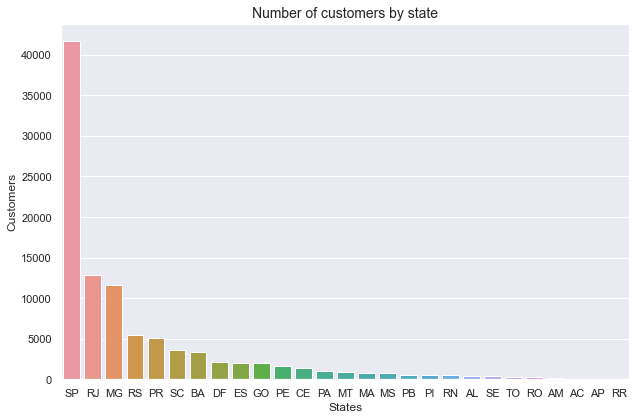

In [6]:
fig = plt.subplots(figsize=(9, 6))
plot = sns.barplot(x=df_customers["customer_state"].value_counts().index, y=df_customers["customer_state"].value_counts(), data=df_customers)
plt.xlabel("States", size=12)
plt.ylabel("Customers", size=12)
plt.title("Number of customers by state", size=14)
plt.tight_layout()
plt.savefig("images/number-of-customer-by-state.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with basic information about customer. Below we can see some descriptions about its columns</p>
    <ul>
        <li>customer_unique_id is the pk.</li>
        <li>There is not missing-values</li>
        <li>There are 96096 customers</li>
        <li>There are 14994 zip codes</li>
        <li>There are 4119 cities</li>
        <li>There are 27 states</li>
        <li>SP (Sao Paulo) has twice as many customers as the second state with the most customers </li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Products</h3>
</div>

In [7]:
df_analysis(df_products, "df_products", columns=["product_id"], type_analysis="complete")


Analysis of df_products dataset
--------------------------------------------------------------------
- Dataset shape:                  32951 rows and 9 columns
- Total of NaN values:            2448
- Percentage of NaN:              0.83 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['product_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 2.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,product_id,object,32951,32951,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,product_weight_g,float64,32949,2204,2,0.01000,2276.47249,0.00000,300.00000,700.00000,1900.00000,40425.00000,4282.03873
6,product_length_cm,float64,32949,99,2,0.01000,30.81508,7.00000,18.00000,25.00000,38.00000,105.00000,16.91446
7,product_height_cm,float64,32949,102,2,0.01000,16.93766,2.00000,8.00000,13.00000,21.00000,105.00000,13.63755
8,product_width_cm,float64,32949,95,2,0.01000,23.19673,6.00000,15.00000,20.00000,30.00000,118.00000,12.07905
1,product_category_name,object,32341,73,610,1.85000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name_lenght,float64,32341,66,610,1.85000,48.47695,5.00000,42.00000,51.00000,57.00000,76.00000,10.24574
3,product_description_lenght,float64,32341,2960,610,1.85000,771.49528,4.00000,339.00000,595.00000,972.00000,3992.00000,635.11522
4,product_photos_qty,float64,32341,19,610,1.85000,2.18899,1.00000,1.00000,1.00000,3.00000,20.00000,1.73677


In [8]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


<div class="alert alert-block alert-info">
    <p>Identifying the categories with more products</p>
</div>

In [9]:
df_number_products_category = pd.DataFrame(df_products.groupby(["product_category_name"])["product_id"].count().sort_values(ascending=False).head(20)).reset_index()

In [10]:
df_number_products_category.head()

,product_category_name,product_id
0,cama_mesa_banho,3029
1,esporte_lazer,2867
2,moveis_decoracao,2657
3,beleza_saude,2444
4,utilidades_domesticas,2335


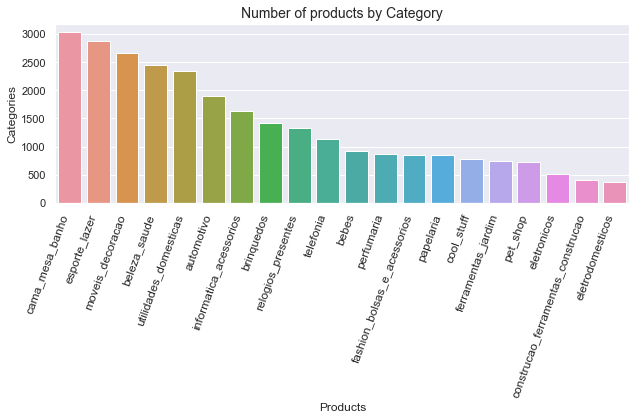

In [11]:
fig = plt.subplots(figsize=(9, 6))
plot = sns.barplot(x=df_number_products_category["product_category_name"], y=df_number_products_category["product_id"], data=df_number_products_category)

plot.set_xticklabels(labels=df_number_products_category["product_category_name"], rotation=70, size=12, horizontalalignment="right")
plt.xlabel("Products", size=12)
plt.ylabel("Categories", size=12)
plt.title("Number of products by Category", size=14)
plt.tight_layout()
plt.savefig("images/number-of-products-by-category.png")
plt.show()

In [12]:
df_correlation_matrix = pd.DataFrame(df_products.corr()).round(2)

In [13]:
mask = np.zeros_like(df_correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True 

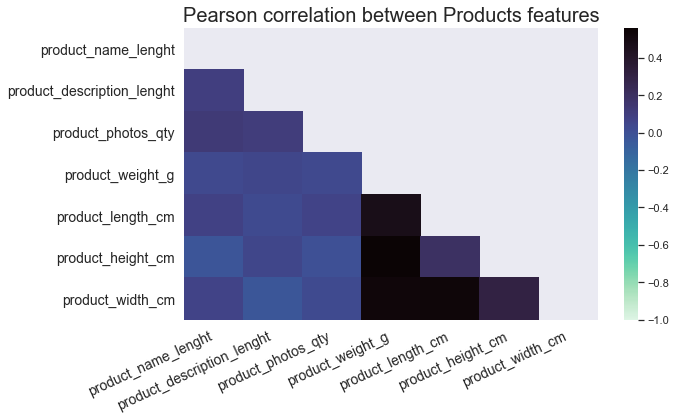

In [14]:
plt.figure(figsize=(10,6))
plt.title("Pearson correlation between Products features", size=20)

ax = sns.heatmap(df_correlation_matrix, mask=mask, vmin=-1, cmap="mako_r")

plt.xticks(rotation=25, size=14, horizontalalignment="right")
plt.yticks(rotation=0, size=14)
plt.tight_layout()
plt.savefig("images/pearson-correlation-between-products-features.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with information about products. Below we can see some descriptions about its columns</p>
    <ul>
        <li>product_id is the pk.</li>
        <li>There are some missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.1. Product translations</h4>
</div>

In [15]:
df_analysis(df_product_category_name_translations, "df_product_category_name_translations", type_analysis="complete")


Analysis of df_product_category_name_translations dataset
--------------------------------------------------------------------
- Dataset shape:                  71 rows and 2 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True


,name,type,records,# NaN,% NaN
0,product_category_name,object,71,0,0.00000
1,product_category_name_english,object,71,0,0.00000


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.3. Orders</h3>
</div>

In [16]:
df_analysis(df_orders, "df_orders", columns=["order_id"], type_analysis="complete")


Analysis of df_orders dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 8 columns
- Total of NaN values:            4908
- Percentage of NaN:              0.62 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['order_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.


,name,type,records,# NaN,% NaN
0,order_id,object,99441,0,0.00000
1,customer_id,object,99441,0,0.00000
2,order_status,object,99441,0,0.00000
3,order_purchase_timestamp,object,99441,0,0.00000
7,order_estimated_delivery_date,object,99441,0,0.00000
4,order_approved_at,object,99281,160,0.16000
5,order_delivered_carrier_date,object,97658,1783,1.79000
6,order_delivered_customer_date,object,96476,2965,2.98000


In [17]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


<div class="alert alert-block alert-info">
    <p>Analyzing the <b>order status</b></p>
</div>

In [18]:
df_orders["order_status"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [19]:
data_piechart = df_orders["order_status"].sort_values(ascending=False).value_counts().values
labels_piechart = df_orders["order_status"].sort_values(ascending=False).value_counts().index.tolist()
textprops = dict(size=16, color="gray")
colors = ["#5975A4", "#CC8963", "#5F9E6E", "#AD5B5E", "#857AAB", "#7D6D5F", "#D095BF", "#C1B37F"]
explode = (0, 0, 0, 0, 0, 0, 0, 0)

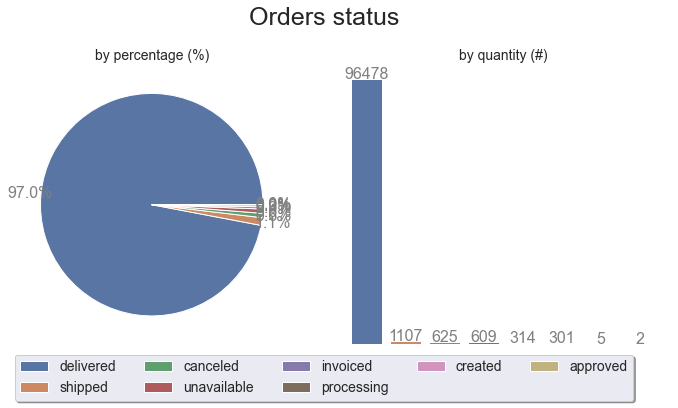

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

fig.suptitle("Orders status", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors):
    ax2.bar(lb, data, label=lb, color=color)
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=1.10, 
        textprops=textprops, colors=[color for color in colors], startangle=0)
ax1.set_title("by percentage (%)", fontsize=14)

fig.legend(labels_piechart, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("images/orders-status.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with order status information. We can say that it is the order header</p>
    <ul>
        <li>order_id can be used as pk.</li>
        <li>There are missing-values in fields related to delivery</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.3.1. Orders payments</h4>
</div>

In [21]:
df_analysis(df_order_payments, "df_order_payments", columns=["order_id"], type_analysis="complete")


Analysis of df_order_payments dataset
--------------------------------------------------------------------
- Dataset shape:                  103886 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['order_id'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 4.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,103886,99440,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,payment_sequential,int64,103886,29,0,0.00000,1.09268,1.00000,1.00000,1.00000,1.00000,29.00000,0.70658
2,payment_type,object,103886,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,payment_installments,int64,103886,24,0,0.00000,2.85335,0.00000,1.00000,1.00000,4.00000,24.00000,2.68705
4,payment_value,float64,103886,29077,0,0.00000,154.10038,0.00000,56.79000,100.00000,171.83750,13664.08000,217.49406


In [22]:
df_order_payments[df_order_payments.duplicated(subset=["order_id"], keep=False)].head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
25,5cfd514482e22bc992e7693f0e3e8df7,2,voucher,1,45.17
35,b2bb080b6bc860118a246fd9b6fad6da,1,credit_card,1,173.84
75,3689194c14ad4e2e7361ebd1df0e77b0,2,voucher,1,57.53
84,723e462ce1ee50e024887c0b403130f3,1,credit_card,1,13.80
102,21b8b46679ea6482cbf911d960490048,2,voucher,1,43.12
121,ea9184ad433a404df1d72fa0a8764232,4,voucher,1,22.49
139,82ffe097d8ddbf319a523b9bbe7725d5,2,voucher,1,30.00
161,c61e3efc183db6b89f5556efb5aa8797,1,credit_card,1,45.50
164,487c1451b8fd7347d0e80e5aca887e91,2,voucher,1,30.00
166,65c863d90026e9dd4888e28d2135c983,2,voucher,1,50.00


In [23]:
df_order_payments[df_order_payments["order_id"] == "ea9184ad433a404df1d72fa0a8764232"]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
121,ea9184ad433a404df1d72fa0a8764232,4,voucher,1,22.49
40168,ea9184ad433a404df1d72fa0a8764232,1,credit_card,1,17.78
78613,ea9184ad433a404df1d72fa0a8764232,3,voucher,1,22.49
94151,ea9184ad433a404df1d72fa0a8764232,2,voucher,1,22.49
99425,ea9184ad433a404df1d72fa0a8764232,5,voucher,1,22.47


<div class="alert alert-block alert-info">
    <p>Analyzing the <b>payment methods</b></p>
</div>

In [24]:
df_order_payments["payment_type"].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [25]:
data_piechart = df_order_payments["payment_type"].sort_values(ascending=False).value_counts().values
labels_piechart = df_order_payments["payment_type"].sort_values(ascending=False).value_counts().index.tolist()
textprops = dict(size=16, color="gray")
colors = ["#5975A4", "#CC8963", "#5F9E6E", "#AD5B5E", "#857AAB"]
explode = (0, 0, 0, 0, 0)

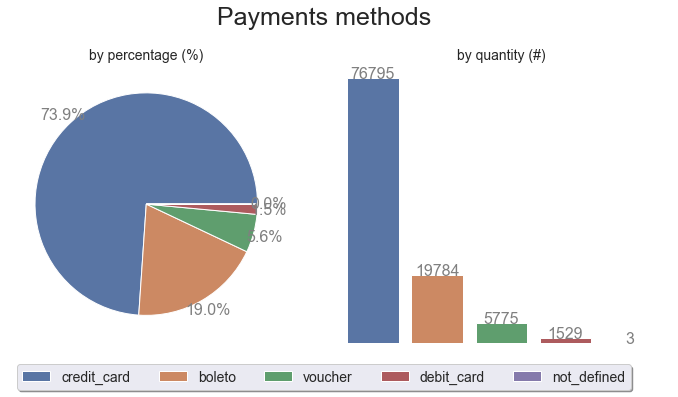

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

fig.suptitle("Payments methods", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors):
    ax2.bar(lb, data, label=lb, color=color)
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=1.10, 
        textprops=textprops, colors=[color for color in colors], startangle=0)
ax1.set_title("by percentage (%)", fontsize=14)

fig.legend(labels_piechart, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("images/Payments-methods.png")
plt.show()

<div class="alert alert-block alert-info">
    <p>Analyzing the <b>payment values</b></p>
</div>

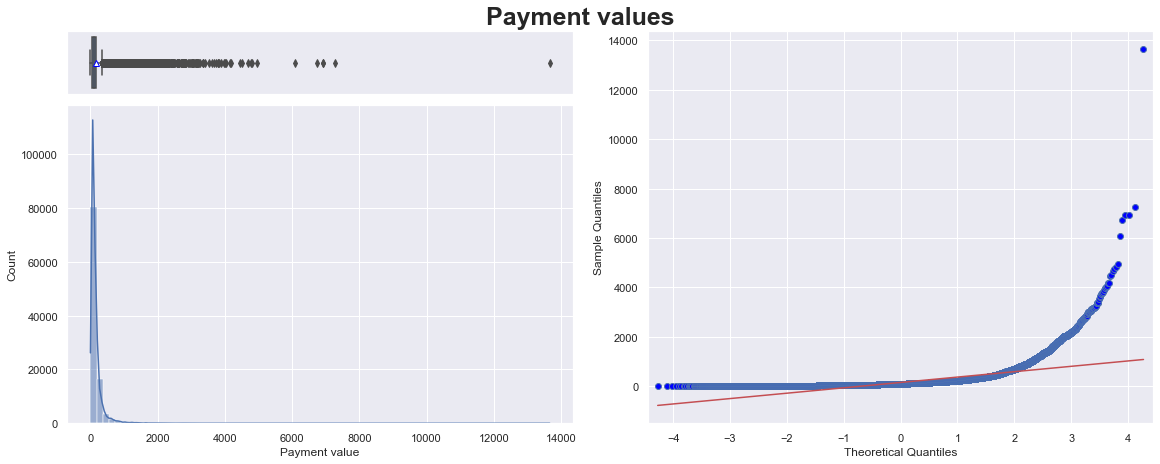


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,payment_value,Shapiro-Wilk,"Statistics=0.478, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,payment_value,D’Agostino’s K^2,"Statistics=159622.787, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,payment_value,Kolmogorov-Smirnov,"Statistics=0.994, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [27]:
fig = plt.figure(constrained_layout=True, figsize=[16,6])
fig.suptitle("Payment values", size=25, fontweight="bold", y=1.05)
spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

ax_box = fig.add_subplot(spec[0, 0])
ax_hist = fig.add_subplot(spec[1, 0])
ax_qqplot = fig.add_subplot(spec[:, 1])

# Boxplot
boxplot = sns.boxplot(data=df_order_payments, x=df_order_payments["payment_value"], showmeans=True, ax=ax_box,
                      meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
ax_box.set(xlabel="", xticks=[])
ax_box.set(yticks=[])
boxplot.set_title("")

# Histplot
sns.histplot(data=df_order_payments, x=df_order_payments["payment_value"], bins=75,  kde=True,  ax=ax_hist)
ax_hist.set(xlabel="Payment value")

# QQplot
qqplot(df_order_payments["payment_value"], line='s', ax=ax_qqplot)

plt.savefig("images/qqplot-of-payment-values.png")
plt.show()

print("\nMaking the Normality Test")
print("---------------------------------")
normality_test(df_order_payments[["payment_value"]])
print("\n")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with details of order payments. The customer can puy the same order through several  payment methods</p>
    <ul>
        <li>The same order can have differents payments methods</li>
        <li>The payments values doesn't have a normal distribution</li>
        <li>There is not a pk</li>
        <li>There are not missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.3.2. Orders reviews</h4>
</div>

In [28]:
df_analysis(df_order_reviews, "df_order_reviews", columns=["review_id"], type_analysis="complete")


Analysis of df_order_reviews dataset
--------------------------------------------------------------------
- Dataset shape:                  100000 rows and 7 columns
- Total of NaN values:            146532
- Percentage of NaN:              20.93 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['review_id'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 5.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,review_id,object,100000,99173,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,order_id,object,100000,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,review_score,int64,100000,5,0,0.00000,4.07089,1.00000,4.00000,5.00000,5.00000,5.00000,1.35966
5,review_creation_date,object,100000,637,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,review_answer_timestamp,object,100000,99010,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_comment_message,object,41753,36921,58247,58.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,review_comment_title,object,11715,4600,88285,88.28000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_order_reviews[df_order_reviews.duplicated(subset=["order_id"], keep=False) & df_order_reviews["review_comment_message"].notnull()].head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1063,9c0ff4d25d28bd004057ce16540abc3d,45390ff93f092f0de1524d486a172c33,1,NaN,A mercadoria não foi entregue ainda..,2018-03-21 00:00:00,2018-03-26 22:01:59
1119,c8d187a7c6b2a9ae76018912fc5711c3,0e457aee274ec7e2e18d25ab6d212921,5,NaN,O produto é muito lindo e está com preço excel...,2018-01-01 00:00:00,2018-01-03 14:46:29
1612,b06f6882b1c0bc82ddf057b58b86fe50,2daee070f2042c8b7a8e9fdde778a31a,5,Muito bom,"Ótimo, excelente produto recomendo a todos",2018-07-12 00:00:00,2018-07-13 10:49:12
1983,a59277055ee75dc9a536fd48e9c2946e,f0fbc60d51bb40c156688d9ce008237f,2,NaN,Foi entregue uma quantidade do produto. Sendo ...,2018-01-31 00:00:00,2018-02-01 13:52:17
2000,03a6a25db577d0689440933055111897,2acfdc5131ff2cf4433e668454c9784c,5,NaN,Muito Bom! Gostei Bastante! Tecido Ótimo! Aten...,2017-12-15 00:00:00,2017-12-16 01:32:18


In [30]:
df_order_reviews.loc[df_order_reviews["order_id"] == "0e457aee274ec7e2e18d25ab6d212921"]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1119,c8d187a7c6b2a9ae76018912fc5711c3,0e457aee274ec7e2e18d25ab6d212921,5,NaN,O produto é muito lindo e está com preço excel...,2018-01-01 00:00:00,2018-01-03 14:46:29
90279,58b4629d5cf0507f7f8b9ae84c146544,0e457aee274ec7e2e18d25ab6d212921,5,NaN,"Excelente qualidade dos adesivos, entrega supe...",2018-01-04 00:00:00,2018-01-04 17:40:42


In [31]:
df_order_reviews[df_order_reviews.duplicated(subset=["review_id"], keep=False) & df_order_reviews["review_comment_message"].notnull()].head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
348,f4d74b17cd63ee35efa82cd2567de911,f269e83a82f64baa3de97c2ebf3358f6,3,NaN,"A embalagem deixou a desejar, por pouco o prod...",2018-01-12 00:00:00,2018-01-13 18:46:10
837,6ec93e77f444e0b1703740a69122e35d,d8cbc79d1dd84f3c87cb2ca7663c930e,5,NaN,Vendedor compromisso do vou o cliente,2017-10-07 00:00:00,2017-10-07 19:47:11
992,1f5aa5d7c3ee7895e4d223797b5a5f2d,c79bdf061e22288609201ec60deb42fb,5,NaN,Tudo ocorreu de forma eficiente,2017-05-10 00:00:00,2017-05-12 00:58:11
1016,3242cc306a9218d0377831e175d62fbf,711246846695fa895c1776f0ddc30b20,5,NaN,Ótimo,2017-07-21 00:00:00,2017-07-22 01:06:37
1489,b703764760e6e5d534a8940a12fca101,2b49d60af10ea7e2443376987ec8a184,1,NaN,Só veio uma capa comprei 3 aí paguei. Mais de ...,2017-04-11 00:00:00,2017-04-14 11:02:46


In [32]:
df_order_reviews.loc[df_order_reviews["review_id"] == "f4d74b17cd63ee35efa82cd2567de911"]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
348,f4d74b17cd63ee35efa82cd2567de911,f269e83a82f64baa3de97c2ebf3358f6,3,NaN,"A embalagem deixou a desejar, por pouco o prod...",2018-01-12 00:00:00,2018-01-13 18:46:10
91014,f4d74b17cd63ee35efa82cd2567de911,a60c9bf6dcdd39e9f1c10ae5ad77c24d,3,NaN,"A embalagem deixou a desejar, por pouco o prod...",2018-01-12 00:00:00,2018-01-13 18:46:10


<div class="alert alert-block alert-info">
    <p>Analyzing the <b>reviews scores</b></p>
</div>

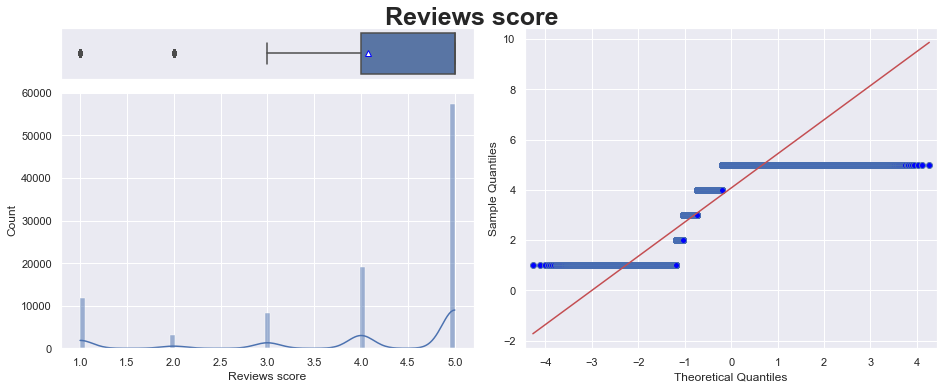


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,review_score,Shapiro-Wilk,"Statistics=0.693, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,review_score,D’Agostino’s K^2,"Statistics=18404.242, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,review_score,Kolmogorov-Smirnov,"Statistics=0.859, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [33]:
fig = plt.figure(constrained_layout=True, figsize=[13,5])
fig.suptitle("Reviews score", size=25, fontweight="bold", y=1.05)
spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

ax_box = fig.add_subplot(spec[0, 0])
ax_hist = fig.add_subplot(spec[1, 0])
ax_qqplot = fig.add_subplot(spec[:, 1])

# Boxplot
boxplot = sns.boxplot(data=df_order_reviews, x=df_order_reviews["review_score"], showmeans=True, ax=ax_box,
                      meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
ax_box.set(xlabel="", xticks=[])
ax_box.set(yticks=[])
boxplot.set_title("")

# Histplot
sns.histplot(data=df_order_reviews, x=df_order_reviews["review_score"], bins=75,  kde=True,  ax=ax_hist)
ax_hist.set(xlabel="Reviews score")

# QQplot
qqplot(df_order_reviews["review_score"], line='s', ax=ax_qqplot)

plt.savefig("images/qqplot-of-orders-reviews.png")
plt.show()

print("\nMaking the Normality Test")
print("---------------------------------")
normality_test(df_order_reviews[["review_score"]])
print("\n")

In [34]:
data_piechart = df_order_reviews["review_score"].sort_values(ascending=False).value_counts().values
labels_piechart = df_order_reviews["review_score"].sort_values(ascending=False).value_counts().index.tolist()
textprops = dict(size=16, color="gray")
colors = ["#5975A4", "#CC8963", "#5F9E6E", "#AD5B5E", "#857AAB"]
explode = (0, 0, 0, 0, 0)

In [35]:
labels_piechart = ["Five", "Four", "Three", "Two", "One"]

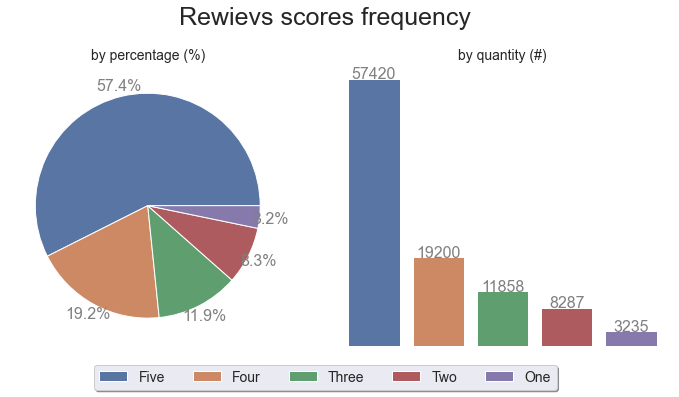

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[10,5])

fig.suptitle("Rewievs scores frequency", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors):
    ax2.bar(lb, data, label=lb, color=color)
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=1.10, 
        textprops=textprops, colors=[color for color in colors], startangle=0)
ax1.set_title("by percentage (%)", fontsize=14)

fig.legend(labels_piechart, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("images/Orders-reviews.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with order reviews. It seems there are reviews repeated for differentes orders</p>
    <ul>
        <li>There is not a pk</li>
        <li>There are missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.3.2. Orders Items</h4>
</div>

In [37]:
df_analysis(df_order_items, "df_order_items", columns=["order_id", "order_item_id"],  type_analysis="complete")


Analysis of df_order_items dataset
--------------------------------------------------------------------
- Dataset shape:                  112650 rows and 7 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['order_id', 'order_item_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 6.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,112650,98666,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,order_item_id,int64,112650,21,0,0.00000,1.19783,1.00000,1.00000,1.00000,1.00000,21.00000,0.70512
2,product_id,object,112650,32951,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,seller_id,object,112650,3095,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,shipping_limit_date,object,112650,93318,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,price,float64,112650,5968,0,0.00000,120.65374,0.85000,39.90000,74.99000,134.90000,6735.00000,183.63393
6,freight_value,float64,112650,6999,0,0.00000,19.99032,0.00000,13.08000,16.26000,21.15000,409.68000,15.80641


In [38]:
df_order_items.sort_values("order_id").head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [39]:
df_order_items[df_order_items["order_id"] == "00143d0f86d6fbd9f9b38ab440ac16f5"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


<div class="alert alert-block alert-info">
    <p>Analyzing the <b>prices</b></p>
</div>

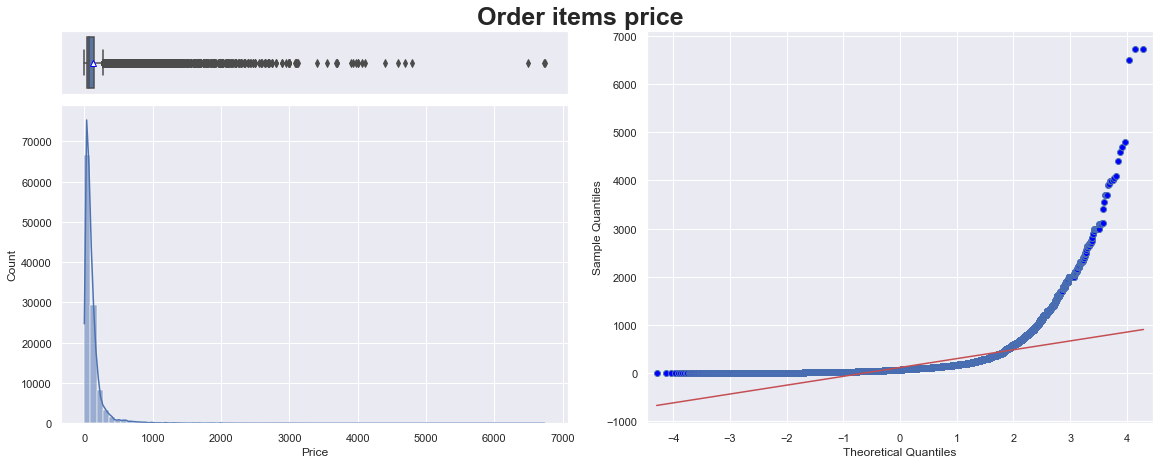


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,price,Shapiro-Wilk,"Statistics=0.460, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,price,D’Agostino’s K^2,"Statistics=155820.644, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,price,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [40]:
fig = plt.figure(constrained_layout=True, figsize=[16,6])
fig.suptitle("Order items price", size=25, fontweight="bold", y=1.05)
spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

ax_box = fig.add_subplot(spec[0, 0])
ax_hist = fig.add_subplot(spec[1, 0])
ax_qqplot = fig.add_subplot(spec[:, 1])

# Boxplot
boxplot = sns.boxplot(data=df_order_items, x=df_order_items["price"], showmeans=True, ax=ax_box,
                      meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
ax_box.set(xlabel="", xticks=[])
ax_box.set(yticks=[])
boxplot.set_title("")

# Histplot
sns.histplot(data=df_order_items, x=df_order_items["price"], bins=75,  kde=True,  ax=ax_hist)
ax_hist.set(xlabel="Price")

# QQplot
qqplot(df_order_items["price"], line='s', ax=ax_qqplot)

# plt.savefig("images/qqplot-of-payment-values.png")
plt.show()

print("\nMaking the Normality Test")
print("---------------------------------")
normality_test(df_order_items[["price"]])
print("\n")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with order products </p>
    <ul>
        <li>order_id together with order_item_id, can be used as pk.<br> It is necessary to consider that a customer can buy the same product several times in the same order</li>
        <li>There are not missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.4. Geolocation</h3>
</div>

In [41]:
df_analysis(df_geolocations, "df_geolocations", columns=["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], type_analysis="complete")


Analysis of df_geolocations dataset
--------------------------------------------------------------------
- Dataset shape:                  1000163 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  261831
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 38.2+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,geolocation_zip_code_prefix,int64,1000163,19015,0,0.00000,36574.16647,1001.00000,11075.00000,26530.00000,63504.00000,99990.00000,30549.33571
1,geolocation_lat,float64,1000163,717360,0,0.00000,-21.17615,-36.60537,-23.60355,-22.91938,-19.97962,45.06593,5.71587
2,geolocation_lng,float64,1000163,717613,0,0.00000,-46.39054,-101.46677,-48.57317,-46.63788,-43.76771,121.10539,4.26975
3,geolocation_city,object,1000163,8011,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,geolocation_state,object,1000163,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_geolocations.sort_values("geolocation_zip_code_prefix").head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1246,1001,-23.549292,-46.633559,sao paulo,SP
429,1001,-23.550498,-46.634338,sao paulo,SP
1182,1001,-23.549779,-46.633957,sao paulo,SP
1435,1001,-23.549292,-46.633559,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP


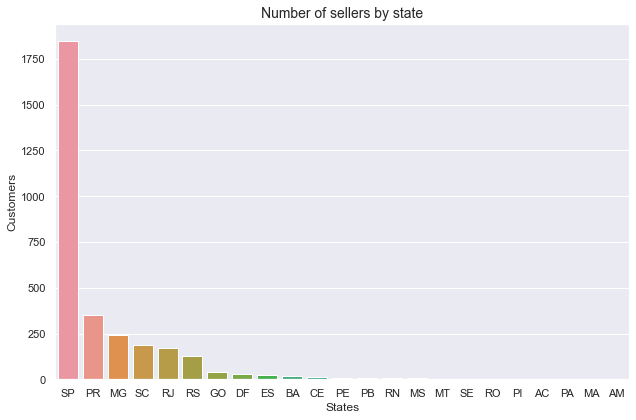

In [43]:
fig = plt.subplots(figsize=(9, 6))
plot = sns.barplot(x=df_sellers["seller_state"].value_counts().index, y=df_sellers["seller_state"].value_counts(), data=df_sellers)
plt.xlabel("States", size=12)
plt.ylabel("Customers", size=12)
plt.title("Number of sellers by state", size=14)
plt.tight_layout()
plt.savefig("images/number-of-sellers-by-state.png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Dataset with geolocation data. There is not a clear relation among this dataset and Customers and Sellers dataset.<br>It is possible to consider only the city, state and zip code</p>
    <ul>
        <li>There is not a pk</li>
        <li>There are missing-values</li>
    </ul>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.5. Sellers</h3>
</div>

In [44]:
df_analysis(df_sellers, "df_sellers", columns=["seller_id"], type_analysis="complete")


Analysis of df_sellers dataset
--------------------------------------------------------------------
- Dataset shape:                  3095 rows and 4 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['seller_id'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 96.8+ KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,seller_id,object,3095,3095,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,seller_zip_code_prefix,int64,3095,2246,0,0.00000,32291.05945,1001.00000,7093.50000,14940.00000,64552.50000,99730.00000,32713.45383
2,seller_city,object,3095,611,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,seller_state,object,3095,23,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Merging datasets and Features Selection</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Based on the <b>mission</b>, we are <b>only</b> going to <b>consider</b> informations/Features related with <b>Customers</b> and <b>Purchases</b></p>
    <p>Below, we can see the meaning of each feature</p>
    <ul style="list-style-type: square;">
        <li><b>Orders</b> (df_orders)</li>
        <ul style="list-style-type: disc;">
           <li><b>order_id :</b> unique identifier of the order.</li>
           <li><b>customer_id :</b> key to the customer dataset. Each order has a unique customer_id.</li>
           <li><b>order_status :</b> Reference to the order status (delivered, shipped, etc).</li>
           <li><b>order_purchase_timestamp :</b> Shows the purchase timestamp.</li>
        </ul>
        <li><b>Order Reviews</b> (df_order_reviews)</li>
        <ul style="list-style-type: disc;">
           <li><b>order_id :</b> unique identifier of the order.</li>
           <li><b>review_score :</b> Note ranging from 1 to 5 given by the customer on a satisfaction survey.</li>
        </ul>
        <li><b>Customers</b> (df_customers)</li>
        <ul style="list-style-type: disc;">
           <li><b>customer_id :</b> key to the orders dataset. Each order has a unique customer_id.</li>
           <li><b>customer_unique_id :</b> unique identifier of a customer.</li>
           <li><b>customer_city :</b> customer city name.</li>
           <li><b>customer_state :</b> customer state.</li>
           <li><b>customer_region :</b> customer region.</li>
        </ul>   
        <li><b>Products</b> (df_products)</li>
        <ul style="list-style-type: disc;">
           <li><b>product_id :</b> unique product identifier.</li>
           <li><b>product_category_name_english :</b> root category of product, in English.</li>
           <li>The following features will be used to treat missing-values in <b>payment_values</b>.</li>
           <ul style="list-style-type: square;"> 
               <li><b>product_length_cm :</b> product length measured in centimeters.</li>
               <li><b>product_weight_g :</b> product weight measured in grams.</li>
               <li><b>product_height_cm :</b> product height measured in centimeters.</li>
               <li><b>product_width_cm :</b> product width measured in centimeters.</li>
           </ul>
        </ul>
        <li><b>Order Items</b> (df_order_items)</li>
        <ul style="list-style-type: disc;">
           <li><b>order_id :</b> unique identifier of the order.</li>            
           <li><b>product_id :</b> unique product identifier.</li>
           <li><b>price :</b> item price.</li>
           <li><b>freight_value :</b> item freight value item (if an order has more than one item the freight value is splitted between items).</li>            
        </ul>        
    </ul>
    
    <p>On the others hands, we have the following dataset that we are not going to use</p>
    
     <ul style="list-style-type: square;">
         <li><b>Sellers</b> (df_sellers) is <b>not interesting</b> for the mission</li>
        <li><b>Order payments</b> (Order_payments) has information about the total value purchased and its methods of payments.</li>
        <ul style="list-style-type: disc;">
           <li><b>payment_type :</b> Method of payment chosen by the customer. <b>Not interesting</b> for the mission.</li>
           <li><b>payment_value :</b> Transaction value. We can get the same value through the sum of <b>price</b> and <b>freight_value</b> based on the <b>Order</b>.</li>
        </ul>
    </ul>
    
    <p>Finally, we have two more datasets used to complete information in other datasets</p>
    
     <ul style="list-style-type: square;">
         <li><b>Geolocation</b> (df_geolocations) This dataset has information Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.</li>
        <li><b>Product category translation</b> (df_product_category_name_translations) Translates the productcategoryname to english..</li>
    </ul>    
</div>

![Entity relationship diagram](images/datasets_to_work_with.png)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. Orders</h3>
</div>

In [45]:
data = df_orders[["order_id", "customer_id", "order_status", "order_purchase_timestamp"]].copy()

In [46]:
df_analysis(data, "data", type_analysis="complete")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 4 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True


,name,type,records,# NaN,% NaN
0,order_id,object,99441,0,0.00000
1,customer_id,object,99441,0,0.00000
2,order_status,object,99441,0,0.00000
3,order_purchase_timestamp,object,99441,0,0.00000


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.2. Reviews</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Veriying duplicates in <b>Reviews</b> before merging with <b>Orders</b></p>
</div>

In [47]:
df_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [48]:
df_order_reviews["duplicated"] = df_order_reviews.duplicated(["order_id"], keep=False)
df_order_reviews[df_order_reviews["duplicated"] == True].count()

review_id                  1114
order_id                   1114
review_score               1114
review_comment_title         36
review_comment_message      399
review_creation_date       1114
review_answer_timestamp    1114
duplicated                 1114
dtype: int64

In [49]:
pd.set_option("display.max_rows", None) # show full of showing rows
pd.set_option("display.max_columns", None) # show full of showing cols
pd.set_option("display.max_colwidth", None) # show full width of showing cols
pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    

In [50]:
df_order_reviews[df_order_reviews["duplicated"] == True].sort_values(["order_id"]).head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,duplicated
25802,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12,True
22585,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,"Estou acostumada a comprar produtos pelo baratheon. Super confiável, transparência, qualidade e agilidade. Super recomendo.",2017-08-25 00:00:00,2017-08-29 21:45:57,True
22946,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22 00:00:00,2018-02-23 12:12:30,True
69191,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04 00:00:00,2018-03-05 17:02:00,True
83893,d8e8c42271c8fb67b9dad95d98c8ff80,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:47,True
857,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:06,True
90601,0c8e7347f1cdd2aede37371543e3d163,02355020fd0a40a0d56df9f6ff060413,3,NaN,UM DOS PRODUTOS (ENTREGA02) COMPRADOS NESTE PEDIDO NAO RECEBI AINDA E OUTRO (ENTREGA01) RECEBI EMAIL QUE ESTA COM DIFICULDADES NA ENTREGA E NÃO TIVE MAIS NOTICIAS,2018-03-21 00:00:00,2018-03-22 01:32:08,True
17708,017f0e1ea6386de662cbeba299c59ad1,02355020fd0a40a0d56df9f6ff060413,1,NaN,ja reclamei varias vezes e ate hoje não sei onde foi parar o produto que comprei. quero cancelar esta compra e quero meu dinheiro de volta.,2018-03-29 00:00:00,2018-03-30 03:16:19,True
38195,04d945e95c788a3aa1ffbee42105637b,029863af4b968de1e5d6a82782e662f5,5,NaN,NaN,2017-07-14 00:00:00,2017-07-17 13:58:06,True
55564,61fe4e7d1ae801bbe169eb67b86c6eda,029863af4b968de1e5d6a82782e662f5,4,NaN,NaN,2017-07-19 00:00:00,2017-07-20 12:06:11,True


In [51]:
pd.reset_option("display.max_rows") # reset max of showing rows
pd.reset_option("display.max_columns") # reset max of showing cols
pd.reset_option("display.max_colwidth") # reset width of showing cols
pd.reset_option("display.float_format") # reset show full content in cell

<div class="alert alert-block alert-warning">
    <p>There are <b>more than one review</b> by <b>Order</b></p>
    <p>In these cases, we are going to use the <b>review score average</b> to delete duplicates <b>Orders reviews</b></p>
</div>

In [52]:
df_temp_order_reviews = df_order_reviews[df_order_reviews["duplicated"] == True].sort_values(["order_id"]).reset_index()
df_temp_order_reviews.shape

(1114, 9)

In [53]:
df_temp_order_reviews = df_temp_order_reviews[["order_id", "review_score"]]
df_temp_order_reviews.head()

,order_id,review_score
0,0035246a40f520710769010f752e7507,5
1,0035246a40f520710769010f752e7507,5
2,013056cfe49763c6f66bda03396c5ee3,5
3,013056cfe49763c6f66bda03396c5ee3,4
4,0176a6846bcb3b0d3aa3116a9a768597,5


<div class="alert alert-block alert-info">
    <p>Calculating the <b>review score average</b> in duplicates</p>
</div>

In [54]:
df_temp_order_reviews_avg = df_temp_order_reviews.groupby(["order_id"]).mean()
df_temp_order_reviews_avg.head()

,review_score
order_id,
0035246a40f520710769010f752e7507,5.0
013056cfe49763c6f66bda03396c5ee3,4.5
0176a6846bcb3b0d3aa3116a9a768597,5.0
02355020fd0a40a0d56df9f6ff060413,2.0
029863af4b968de1e5d6a82782e662f5,4.5


In [55]:
df_temp_order_reviews_avg = df_temp_order_reviews_avg.reset_index()
df_temp_order_reviews_avg.head()

,order_id,review_score
0,0035246a40f520710769010f752e7507,5.0
1,013056cfe49763c6f66bda03396c5ee3,4.5
2,0176a6846bcb3b0d3aa3116a9a768597,5.0
3,02355020fd0a40a0d56df9f6ff060413,2.0
4,029863af4b968de1e5d6a82782e662f5,4.5


<div class="alert alert-block alert-info">
    <p><b>Deleting</b> the <b>review score</b> duplicated to add the <b>review score average</b> </p>
</div>

In [56]:
df_order_reviews.drop(df_order_reviews.index[df_order_reviews["duplicated"] == True], inplace=True)

In [57]:
df_order_reviews[df_order_reviews["duplicated"] == True].sort_values(["order_id"]).head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,duplicated


In [58]:
df_temp_order_reviews = df_order_reviews[["order_id", "review_score"]]
df_temp_order_reviews.head()

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5
3,658677c97b385a9be170737859d3511b,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,5


<div class="alert alert-block alert-info">
    <p><b>Concatenating</b> the <b>review score average</b> </p>
</div>

In [59]:
df_temp_order_reviews = pd.concat([df_temp_order_reviews, df_temp_order_reviews_avg], ignore_index=True)

<div class="alert alert-block alert-info">
    <p>Merging <b>Reviews</b> with <b>Orders</b></p>
</div>

In [60]:
data = data.merge(right=df_temp_order_reviews[["order_id", "review_score"]], on="order_id", how="left")

In [61]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,5.0


In [62]:
df_analysis(data, "data", type_analysis="complete")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 4.6+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,99441,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_id,object,99441,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_status,object,99441,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,object,99441,98875,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,99441,11,0,0.00000,4.07123,1.00000,4.00000,5.00000,5.00000,5.00000,1.35841


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.3. Customer and Geolocations</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are only going to keep one geolocation for each zip code to mix them with customers</p>
    <p>At the same time, we are going to add the fiel <b>Region</b> into Geolocations dataset</p>
</div>

In [63]:
df_geolocations.drop_duplicates(subset=["geolocation_zip_code_prefix"], keep="first", inplace=True)

In [64]:
df_geolocations = df_geolocations.merge(right=df_brasil_regions[["region", "state_acronym"]], right_on="state_acronym", left_on="geolocation_state", how="left")

In [65]:
df_geolocations["geolocation_region"] = df_geolocations["region"]
df_geolocations.drop(columns=["region", "state_acronym"], axis=1, inplace=True)

In [66]:
df_analysis(df_geolocations, "df_geolocations", type_analysis="complete")


Analysis of df_geolocations dataset
--------------------------------------------------------------------
- Dataset shape:                  19015 rows and 6 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,geolocation_zip_code_prefix,int64,19015,19015,0,0.00000,42711.59190,1001.00000,12721.50000,38240.00000,70656.50000,99990.00000,30905.05175
1,geolocation_lat,float64,19015,18987,0,0.00000,-19.06209,-36.60537,-23.56439,-22.42925,-15.61545,42.18400,7.31940
2,geolocation_lng,float64,19015,18988,0,0.00000,-46.05801,-72.92730,-49.00044,-46.63254,-43.25532,121.10539,5.38075
3,geolocation_city,object,19015,5955,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,geolocation_state,object,19015,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,geolocation_region,object,19015,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
df_geolocations.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geolocation_region
0,1037,-23.545621,-46.639292,sao paulo,SP,Southeast
1,1046,-23.546081,-46.644820,sao paulo,SP,Southeast
2,1041,-23.544392,-46.639499,sao paulo,SP,Southeast
3,1035,-23.541578,-46.641607,sao paulo,SP,Southeast
4,1012,-23.547762,-46.635361,são paulo,SP,Southeast


<div class="alert alert-block alert-info">
    <p>Merging <b>Geolocation</b> with <b>Customers</b></p>
    <p>First of all, we are going to verify that all Zip Codes in <b>Customers</b> are in <b>Geolocation</b></p>
</div>

In [68]:
df_customers["zip_code_in_geolocation"] = df_customers["customer_zip_code_prefix"].isin(df_geolocations["geolocation_zip_code_prefix"])
df_customers[df_customers["zip_code_in_geolocation"] == False]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,zip_code_in_geolocation
354,ecb1725b26e8b8c458181455dfa434ea,b55a113bb84fc10eaf58c6d09ec69794,72300,brasilia,DF,False
382,bcf86029aeed4ed8bac0e16eb14c22f5,7cd7974c9f79f75b77f323878ef87f43,11547,cubatao,SP,False
877,f4302056f0c58570522590f8181de2c7,67b05b597a66b5c449025000b9430abb,64605,picos,PI,False
1218,03bbe0ce5c28e05f22917607db798818,8f3dca4306d5a89e4ae2c65c110603a2,72465,brasilia,DF,False
1272,ad4950aded55c2ea376be59506456d68,aa2b96dd03307ea6dc4b763c0b5f0b39,7729,caieiras,SP,False
...,...,...,...,...,...,...
97467,cf818420383856a129134f5f8343f7b8,795c495a65f983b242fb01bd507977c5,72338,brasilia,DF,False
97780,67f3e907dce402e696b15f9308ff22ed,6f232f2f5c7f33b7bd9d794d2afacadd,68629,paragominas,PA,False
98140,f792e419335df11d82c32efcfb09c51b,c04c085b8e7573ba87b9ae1968d0985e,28530,sao sebastiao do paraiba,RJ,False
98878,78a11bb1fa72f556996b9a5b9bcd0629,e7536f62a200b415edd9491ac12a17fa,55863,siriji,PE,False


<div class="alert alert-block alert-warning">
    <p>Not all Zip Codes in <b>Customers</b> are in <b>Geolocation</b></p>
    <p>Due to that, we are going to add the Region through the state</p>
</div>

In [69]:
df_temp_geolocations = df_geolocations[["geolocation_state", "geolocation_region"]].copy()

In [70]:
df_temp_geolocations.drop_duplicates(subset=["geolocation_state"], keep="first", inplace=True)

In [71]:
df_temp_geolocations["geolocation_state"].unique()

array(['SP', 'RJ', 'ES', 'MG', 'BA', 'SE', 'PE', 'RN', 'AL', 'PB', 'CE',
       'PI', 'MA', 'PA', 'AP', 'AM', 'RR', 'AC', 'DF', 'GO', 'RO', 'TO',
       'MT', 'MS', 'PR', 'SC', 'RS'], dtype=object)

In [72]:
df_analysis(df_temp_geolocations, "df_temp_geolocations", type_analysis="complete")


Analysis of df_temp_geolocations dataset
--------------------------------------------------------------------
- Dataset shape:                  27 rows and 2 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True


,name,type,records,# NaN,% NaN
0,geolocation_state,object,27,0,0.00000
1,geolocation_region,object,27,0,0.00000


In [73]:
df_temp_customers = df_customers.merge(right=df_temp_geolocations[["geolocation_state", "geolocation_region"]], 
                                      right_on="geolocation_state", left_on="customer_state", how="left")

df_temp_customers["customer_region"] = df_temp_customers["geolocation_region"]

df_temp_customers.drop(columns=["geolocation_state", "geolocation_region", "zip_code_in_geolocation"], axis=1, inplace=True)

In [74]:
df_analysis(df_temp_customers, "df_temp_customers", columns=["customer_unique_id"], type_analysis="complete")


Analysis of df_temp_customers dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 6 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['customer_unique_id'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 5.3+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_id,object,99441,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,99441,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,customer_zip_code_prefix,int64,99441,14994,0,0.00000,35137.47458,1003.00000,11347.00000,24416.00000,58900.00000,99990.00000,29797.93900
3,customer_city,object,99441,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,customer_state,object,99441,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,customer_region,object,99441,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info">
    <p>Merging <b>Customers</b> with <b>Orders</b></p>
</div>

In [75]:
data = data.merge(right=df_temp_customers[["customer_id", "customer_unique_id", "customer_city", "customer_state", "customer_region"]], on="customer_id", how="left")

In [76]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,review_score,customer_unique_id,customer_city,customer_state,customer_region
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,4.0,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,Southeast
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,4.0,af07308b275d755c9edb36a90c618231,barreiras,BA,Northeast
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,5.0,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,Central
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,5.0,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,RN,Northeast
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,5.0,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,SP,Southeast


In [77]:
df_analysis(data, "data", type_analysis="complete")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  99441 rows and 9 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 7.6+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,99441,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_id,object,99441,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_status,object,99441,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,object,99441,98875,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,99441,11,0,0.00000,4.07123,1.00000,4.00000,5.00000,5.00000,5.00000,1.35841
5,customer_unique_id,object,99441,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,customer_city,object,99441,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,customer_state,object,99441,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,customer_region,object,99441,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.4. Products and Orders items</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to merge the products datasets with products translations dataset</p>
</div>

In [78]:
df_product_category_name_translations.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [79]:
df_products = df_products.merge(right=df_product_category_name_translations[["product_category_name", "product_category_name_english"]], on="product_category_name", how="left")

In [80]:
df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [81]:
print("Number of \"products categories\" to complete with \"products categories translated\" is:",
        df_products[(df_products["product_category_name"].isna()) & (df_products["product_category_name_english"].notnull())].shape[0]
)

Number of "products categories" to complete with "products categories translated" is: 0


In [82]:
print("Number of \"products categories translated\" to complete with \"products categories\" is:",
        df_products[(df_products["product_category_name_english"].isna()) & (df_products["product_category_name"].notnull())].shape[0]
)

Number of "products categories translated" to complete with "products categories" is: 13


<div class="alert alert-block alert-info">
    <p>Fill products categories translated with the original name of category</p>
</div>

In [83]:
df_products["product_category_name_english"].fillna(df_products["product_category_name"], inplace=True)

In [84]:
print("Number of \"products categories translated\" to complete with \"products categories\" is:",
        df_products[(df_products["product_category_name_english"].isna()) & (df_products["product_category_name"].notnull())].shape[0]
)

Number of "products categories translated" to complete with "products categories" is: 0


In [85]:
del df_products["product_category_name"]

<div class="alert alert-block alert-info">
    <p>Merging <b>Products</b> with <b>Orders items</b></p>
</div>

In [86]:
df_temp_order_items = df_order_items.merge(right=df_products[["product_id", "product_category_name_english", "product_weight_g",
                                                              "product_length_cm", "product_height_cm", "product_width_cm"]], on="product_id", how="left")

In [87]:
df_temp_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,furniture_decor,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumery,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,garden_tools,3750.0,35.0,40.0,30.0


<div class="alert alert-block alert-info">
    <p>Consolidating <b>price</b> with <b>freight_value</b></p>
    <p>Later, we check whether these consolidation is consisten</p>
    
</div>

In [88]:
df_temp_order_items["price_plus_freight_value"] = df_temp_order_items["price"] + df_temp_order_items["freight_value"] 

In [89]:
df_temp_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price_plus_freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,650.0,28.0,9.0,14.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,30000.0,50.0,30.0,40.0,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,furniture_decor,3050.0,33.0,13.0,33.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumery,200.0,16.0,10.0,15.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,garden_tools,3750.0,35.0,40.0,30.0,218.04


<div class="alert alert-block alert-info">
    <p>Merging <b>Orders items</b> with <b>Orders</b></p>
</div>

In [90]:
data.shape

(99441, 9)

In [91]:
data = data.merge(right=df_temp_order_items[["order_id", "price_plus_freight_value", "product_category_name_english", "product_weight_g",
                                                              "product_length_cm", "product_height_cm", "product_width_cm"]], on="order_id", how="left")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.4.1. Checking coherence of the payment_value</h4>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to check whether <b>price</b> plus <b>freight_value</b> are coherence with <b>payment_value</b></p>
    <p>To do that, we are going to select an order greater than 1 and less than 5 products to compare the values</p>
</div>

In [92]:
df_temp_order_items.loc[(df_temp_order_items["order_item_id"] > 1) & (df_temp_order_items["order_item_id"] < 5)].sort_values(["order_item_id"], ascending=False).head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price_plus_freight_value
112643,fffb9224b6fc7c43ebb0904318b10b5f,4,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19,watches_gifts,350.0,16.0,14.0,11.0,89.19
42310,605cb018bbe790a8132db79998de4eab,4,e56b42f71554ce1f5b7dbd07ec8dca6d,1900267e848ceeba8fa32d80c1a5f5a8,2017-12-05 02:18:33,39.99,16.11,bed_bath_table,850.0,16.0,10.0,16.0,56.10
11097,193a665b822ac18f6b67b7705da3d66c,4,4b703444923b5e57bb73ba343f5ebab7,42b729f859728f5079499127a9c2ef37,2018-05-18 11:14:19,35.90,7.39,bed_bath_table,264.0,17.0,14.0,16.0,43.29


In [93]:
df_temp_order_items[df_temp_order_items["order_id"]=="fffb9224b6fc7c43ebb0904318b10b5f"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name_english,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price_plus_freight_value
112640,fffb9224b6fc7c43ebb0904318b10b5f,1,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19,watches_gifts,350.0,16.0,14.0,11.0,89.19
112641,fffb9224b6fc7c43ebb0904318b10b5f,2,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19,watches_gifts,350.0,16.0,14.0,11.0,89.19
112642,fffb9224b6fc7c43ebb0904318b10b5f,3,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19,watches_gifts,350.0,16.0,14.0,11.0,89.19
112643,fffb9224b6fc7c43ebb0904318b10b5f,4,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19,watches_gifts,350.0,16.0,14.0,11.0,89.19


<div class="alert alert-block alert-info">
    <p>If we do the calculation of <b>price</b> + <b>freight_value</b>, we get a total result of 356.76</p>
    <p>Let's look the same order in <b>df_order_payments</b></p>
</div>

In [94]:
df_order_payments[df_order_payments["order_id"]=="fffb9224b6fc7c43ebb0904318b10b5f"]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
91871,fffb9224b6fc7c43ebb0904318b10b5f,1,boleto,1,356.76


<div class="alert alert-block alert-success">
    <p>Now, we know that we can get the same value</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.5. Analyzing the resulting dataset</h3>
</div>

In [95]:
df_analysis(data, "data", type_analysis="complete")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 15 columns
- Total of NaN values:            6325
- Percentage of NaN:              0.37 %
- Total of full duplicates rows:  10449
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 13.8+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,113425,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_id,object,113425,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_status,object,113425,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,object,113425,98875,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,113425,11,0,0.00000,4.00035,1.00000,3.00000,5.00000,5.00000,5.00000,1.41067
5,customer_unique_id,object,113425,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,customer_city,object,113425,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,customer_state,object,113425,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,customer_region,object,113425,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,price_plus_freight_value,float64,112650,29149,775,0.68000,140.64406,6.08000,55.22000,92.32000,157.93750,6929.31000,190.72439


<div class="alert alert-block alert-info">
    <p>At this point, we can delete <b>customer_id</b> because we have all information together so, we can identify whether an order is a different purchase</p>
</div>

In [96]:
del data["customer_id"]

<div class="alert alert-block alert-info">
    <p>Now, we are going to reorganize the columns and rows</p>
</div>

In [97]:
data.rename(columns={"price_plus_freight_value":"payment_value", "product_category_name_english":"product_category"}, inplace=True)

In [98]:
ORDERED_COLUMNS = [
    "order_id", "customer_unique_id", "order_status", "order_purchase_timestamp", "review_score", 
    "payment_value", "product_category", "product_weight_g", "product_length_cm", "product_height_cm", 
    "product_width_cm", "customer_city", "customer_state", "customer_region"
]

In [99]:
data = data[ORDERED_COLUMNS]
data = data.sort_values(["order_purchase_timestamp", "order_id", "customer_unique_id"], ascending=False)

In [100]:
data.head()

,order_id,customer_unique_id,order_status,order_purchase_timestamp,review_score,payment_value,product_category,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_city,customer_state,customer_region
69370,10a045cdf6a5650c21e9cfeb60384c16,87ab9fec999db8bd5774917de3cdf01c,canceled,2018-10-17 17:30:18,1.0,NaN,NaN,NaN,NaN,NaN,NaN,sorocaba,SP,Southeast
77917,b059ee4de278302d550a3035c4cdb740,262e1f1e26e92e86375f86840b4ffd63,canceled,2018-10-16 20:16:02,5.0,NaN,NaN,NaN,NaN,NaN,NaN,picos,PI,Northeast
36374,a2ac6dad85cf8af5b0afb510a240fe8c,af5454198a97379394cacf676e1e96cb,canceled,2018-10-03 18:55:29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,registro,SP,Southeast
100823,616fa7d4871b87832197b2a137a115d2,634420a0ea42302205032ed44ac7fccc,canceled,2018-10-01 15:30:09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,pirai,RJ,Southeast
57391,392ed9afd714e3c74767d0c4d3e3f477,9bb92bebd4cb7511e1a02d5e50bc4655,canceled,2018-09-29 09:13:03,1.0,NaN,NaN,NaN,NaN,NaN,NaN,guarulhos,SP,Southeast


In [101]:
df_analysis(data, "data", type_analysis="complete")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 14 columns
- Total of NaN values:            6325
- Percentage of NaN:              0.4 %
- Total of full duplicates rows:  10449
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 13.0+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,113425,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,113425,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_status,object,113425,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,object,113425,98875,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,113425,11,0,0.00000,4.00035,1.00000,3.00000,5.00000,5.00000,5.00000,1.41067
11,customer_city,object,113425,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,customer_state,object,113425,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,customer_region,object,113425,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,payment_value,float64,112650,29149,775,0.68000,140.64406,6.08000,55.22000,92.32000,157.93750,6929.31000,190.72439
7,product_weight_g,float64,112632,2204,793,0.70000,2093.67205,0.00000,300.00000,700.00000,1800.00000,40425.00000,3751.59688


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>We got a dataset with details about orders, items in order, customer, total value among other data.</p>
    <ul>
        <li><b>order_id :</b> unique identifier of the order.</li>
        <li><b>customer_id :</b> key to the customer dataset. Each order has a unique customer_id.</li>
        <li><b>order_status :</b> Reference to the order status (delivered, shipped, etc).</li>
        <li><b>order_purchase_timestamp :</b> Shows the purchase timestamp.</li>
        <li><b>review_score :</b> Note ranging from 1 to 5 given by the customer on a satisfaction survey.</li>
        <li><b>customer_city :</b> customer city name.</li>
        <li><b>customer_state :</b> customer state.</li>
        <li><b>customer_region :</b> customer region.</li>
        <li><b>payment_value :</b> item price + item freight value item (if an order has more than one item the freight value is splitted between items).</li>
        <li><b>product_category :</b> root category of product, in English.</li>
        <li><b>product_length_cm :</b> product length measured in centimeters.</li>
        <li><b>product_weight_g :</b> product weight measured in grams.</li>
        <li><b>product_height_cm :</b> product height measured in centimeters.</li>
        <li><b>product_width_cm :</b> product width measured in centimeters.</li>
    </ul>
    <p>In the dataset are as many rows as items by orders</p>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.5.1. Fixing time columns</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Based on the analysis, we can identify that the feature <b>order_purchase_timestamp</b> doesn't have the right type</p>
</div>

In [102]:
data["order_purchase_timestamp"] = data["order_purchase_timestamp"].astype("datetime64")

<div class="alert alert-block alert-info">
    <p>As well, based on the analysis, we can identify the following categorical columns that doesn't have the right type</p>
</div>

In [103]:
CATEGORICAL_COLUMNS = [
    "order_status", "product_category", "customer_city", "customer_state", "customer_region"
]

In [104]:
for col in CATEGORICAL_COLUMNS:
    data[col] = data[col].astype("category")

<div class="alert alert-block alert-info">
    <p>Analyzing the resulting dataset</p>
</div>

In [105]:
df_analysis(data, "data", type_analysis="complete")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 14 columns
- Total of NaN values:            6325
- Percentage of NaN:              0.4 %
- Total of full duplicates rows:  10449
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 13.5+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,113425,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,113425,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_status,category,113425,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,datetime64[ns],113425,98875,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,113425,11,0,0.00000,4.00035,1.00000,3.00000,5.00000,5.00000,5.00000,1.41067
11,customer_city,category,113425,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,customer_state,category,113425,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,customer_region,category,113425,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,payment_value,float64,112650,29149,775,0.68000,140.64406,6.08000,55.22000,92.32000,157.93750,6929.31000,190.72439
7,product_weight_g,float64,112632,2204,793,0.70000,2093.67205,0.00000,300.00000,700.00000,1800.00000,40425.00000,3751.59688


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Treating Outliers</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Analyzing Order status</h3>
</div>

In [106]:
data["order_status"].unique()

['canceled', 'shipped', 'delivered', 'unavailable', 'invoiced', 'processing', 'created', 'approved']
Categories (8, object): ['canceled', 'shipped', 'delivered', 'unavailable', 'invoiced', 'processing', 'created', 'approved']

In [107]:
data["payment_value"].isnull().groupby(data["order_status"]).sum().astype(int).reset_index(name='count').sort_values("count", ascending=False)

,order_status,count
7,unavailable,603
1,canceled,164
2,created,5
4,invoiced,2
6,shipped,1
0,approved,0
3,delivered,0
5,processing,0


In [108]:
data["product_category"].isnull().groupby(data["order_status"]).sum().astype(int).reset_index(name='count').sort_values("count", ascending=False)

,order_status,count
3,delivered,1537
7,unavailable,603
1,canceled,178
6,shipped,28
4,invoiced,14
5,processing,13
2,created,5
0,approved,0


<div class="alert alert-block alert-success">
    <p>For the momento, we are not going to treat <b>order_status</b> outliers</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Analyzing Order purchase time</h3>
</div>

In [109]:
data["order_purchase_timestamp"].max()

Timestamp('2018-10-17 17:30:18')

In [110]:
data["order_purchase_timestamp"].min()

Timestamp('2016-09-04 21:15:19')

<div class="alert alert-block alert-success">
    <p><b>order_purchase_timestamp</b> seems coherent</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.4. Treating outliers in numeric features with Z-Score</h3>
</div>

In [111]:
NUMERIC_COLS = [
    "payment_value", "product_length_cm", "product_weight_g", "product_height_cm", "product_width_cm"
]

data_outliers = pd.DataFrame()

In [112]:
flag = True

for product_category in data["product_category"].unique():
    
    if flag:
        df_temp_outliers = data[data["product_category"].isnull()].copy()
        flag = False
    else:
        # for each property type, we are going to define the max and min threshold to replace outliers
        df_temp_outliers  = data[data["product_category"] == product_category].copy()

        for col in NUMERIC_COLS:

            # Defining the Z Score
            df_temp_outliers[col + "_zscore"] = (df_temp_outliers[col] - df_temp_outliers[col].mean()) / df_temp_outliers[col].std()
            df_temp_outliers.loc[(df_temp_outliers[col + "_zscore"] > 3) | (df_temp_outliers[col + "_zscore"] < -3), col] = np.nan

            del df_temp_outliers[col + "_zscore"]
        
    data_outliers = pd.concat([data_outliers, df_temp_outliers])

<div class="alert alert-block alert-info">
     Analyzing the result
</div>

In [113]:
df_analysis(data_outliers, "data_outliers", type_analysis="complete")


Analysis of data_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 14 columns
- Total of NaN values:            15616
- Percentage of NaN:              0.98 %
- Total of full duplicates rows:  10454
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 9.5+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,113425,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,113425,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_status,category,113425,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,datetime64[ns],113425,98875,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,113425,11,0,0.00000,4.00035,1.00000,3.00000,5.00000,5.00000,5.00000,1.41067
11,customer_city,category,113425,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,customer_state,category,113425,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,customer_region,category,113425,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,product_width_cm,float64,111204,79,2221,1.96000,22.56395,6.00000,15.00000,20.00000,30.00000,100.00000,10.90328
9,product_height_cm,float64,111116,93,2309,2.04000,15.98627,2.00000,8.00000,13.00000,20.00000,105.00000,12.22659


<div class="alert alert-block alert-success">
    <p>The missing values increased to 0.98%</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Univariate analysis</h2>
</div>

<div class="alert alert-block alert-info">
    Before to make missing-values treating, we are going to analyse normal distribution for each continuos variable
</div>

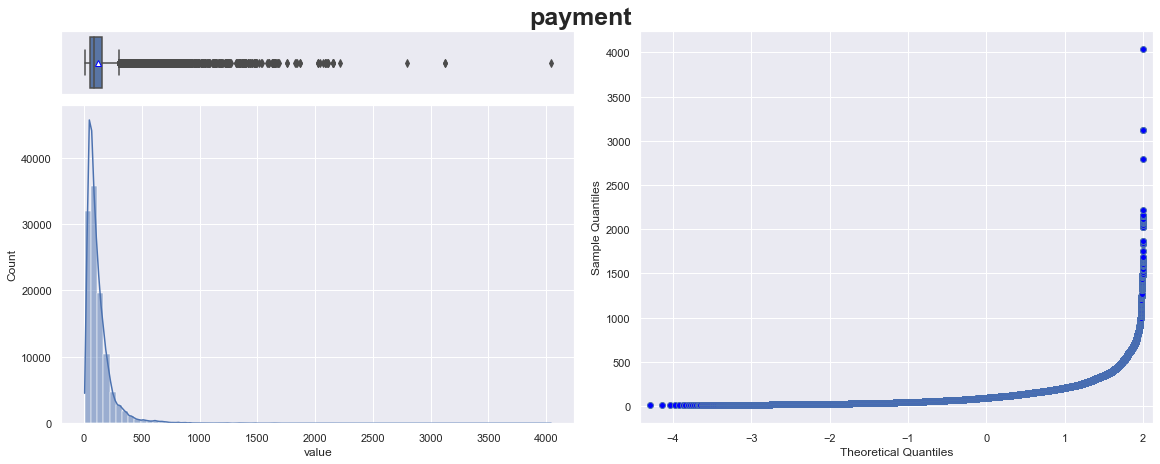


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,payment_value,Shapiro-Wilk,"Statistics=nan, p-value=1.000",Sample looks Gaussian (fail to reject H₀)
1,payment_value,D’Agostino’s K^2,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)
2,payment_value,Kolmogorov-Smirnov,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)


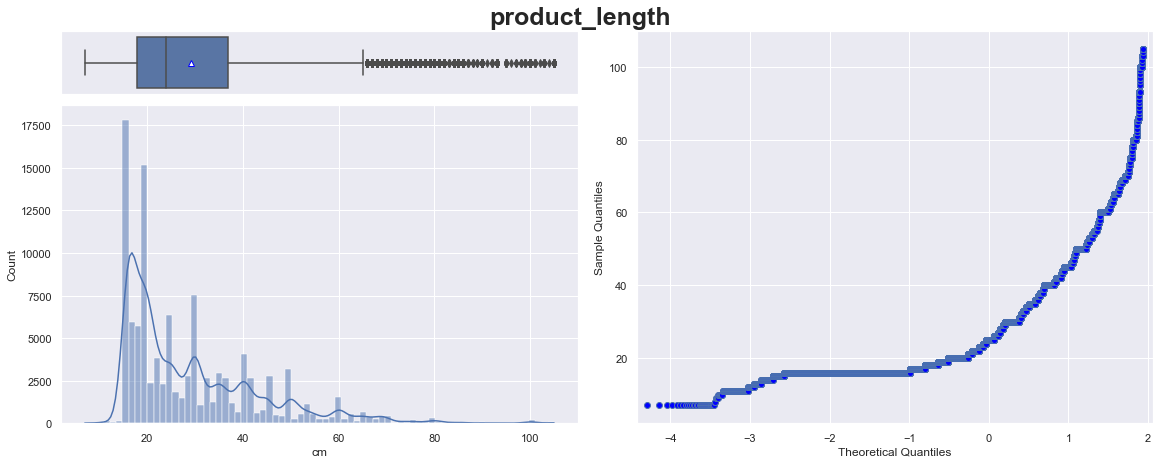


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,product_length_cm,Shapiro-Wilk,"Statistics=nan, p-value=1.000",Sample looks Gaussian (fail to reject H₀)
1,product_length_cm,D’Agostino’s K^2,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)
2,product_length_cm,Kolmogorov-Smirnov,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)


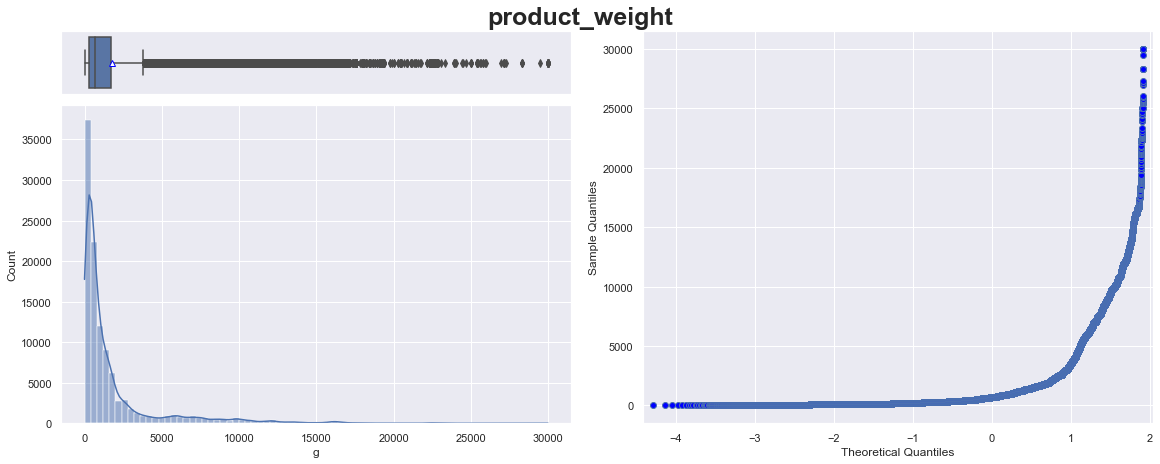


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,product_weight_g,Shapiro-Wilk,"Statistics=nan, p-value=1.000",Sample looks Gaussian (fail to reject H₀)
1,product_weight_g,D’Agostino’s K^2,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)
2,product_weight_g,Kolmogorov-Smirnov,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)


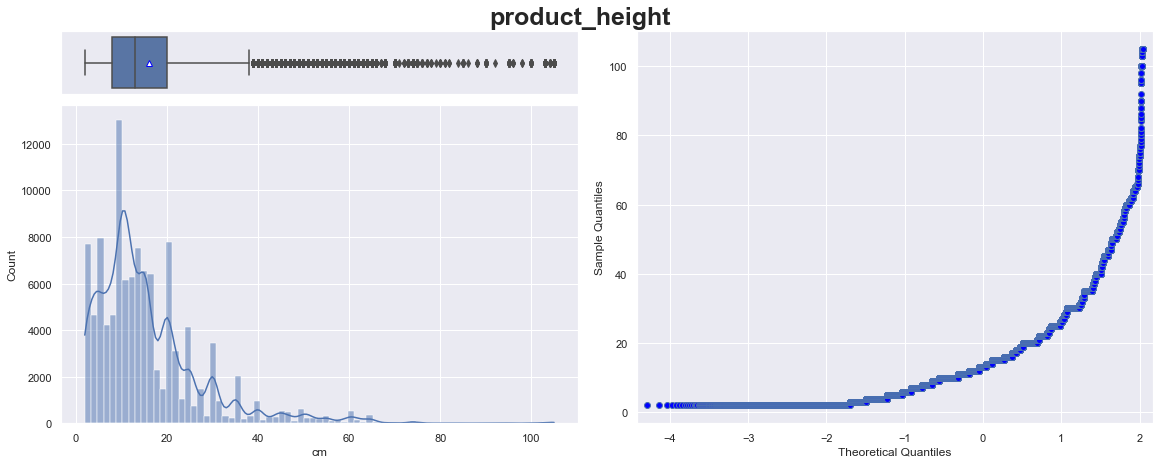


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,product_height_cm,Shapiro-Wilk,"Statistics=nan, p-value=1.000",Sample looks Gaussian (fail to reject H₀)
1,product_height_cm,D’Agostino’s K^2,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)
2,product_height_cm,Kolmogorov-Smirnov,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)


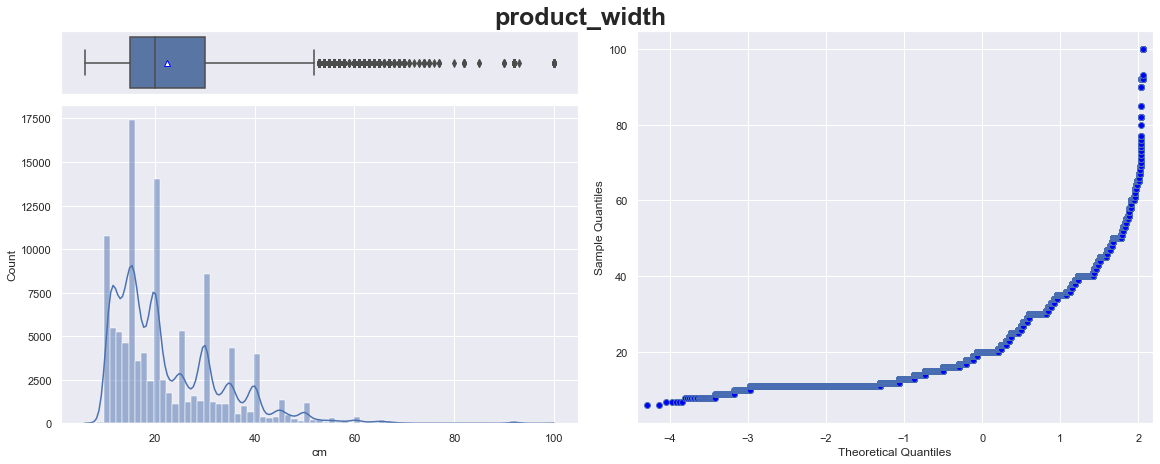


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,product_width_cm,Shapiro-Wilk,"Statistics=nan, p-value=1.000",Sample looks Gaussian (fail to reject H₀)
1,product_width_cm,D’Agostino’s K^2,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)
2,product_width_cm,Kolmogorov-Smirnov,"Statistics=nan, p-value=nan",Sample does not look Gaussian (reject H₀)


In [114]:
for col in NUMERIC_COLS:
    
    var = col.rpartition("_")
    
    fig = plt.figure(constrained_layout=True, figsize=[16,6])
    fig.suptitle(var[0], size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

    ax_box = fig.add_subplot(spec[0, 0])
    ax_hist = fig.add_subplot(spec[1, 0])
    ax_qqplot = fig.add_subplot(spec[:, 1])

    # Boxplot
    boxplot = sns.boxplot(data=data_outliers, x=data_outliers[col], showmeans=True, ax=ax_box,
                          meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
    ax_box.set(xlabel="", xticks=[])
    ax_box.set(yticks=[])
    boxplot.set_title("")

    # Histplot
    sns.histplot(data=data_outliers, x=data_outliers[col], bins=75,  kde=True,  ax=ax_hist)
    ax_hist.set(xlabel=var[-1])

    # QQplot
    qqplot(data_outliers[col], line='s', ax=ax_qqplot)

    plt.savefig("images/qqplot-of-" + var[1] + ".png")
    plt.show()

    print("\nMaking the Normality Test")
    print("---------------------------------")
    normality_test(data_outliers[[col]])
    print("\n")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Continuous Variables Transformation</h3>
</div>
<br>
<div class="alert alert-block alert-info">
     Based on the <b>Univariate analysis</b> where we note that <b>none</b> of the analyzed numeric variables have a <b>Normal distribution</b>
     and <b>all their values are very close</b> so, we are going to apply the <b>Logarithmic transformation</b> in these variables to get a <b>better Normal distribution</b> of these values
</div>

In [115]:
for col in NUMERIC_COLS:
    data_outliers[col + "_log"] = np.log(data_outliers[col] + 1)
    data_outliers[col + "_log2"] = np.log2(data_outliers[col] + 1)
    data_outliers[col + "_log10"] = np.log10(data_outliers[col] + 1)

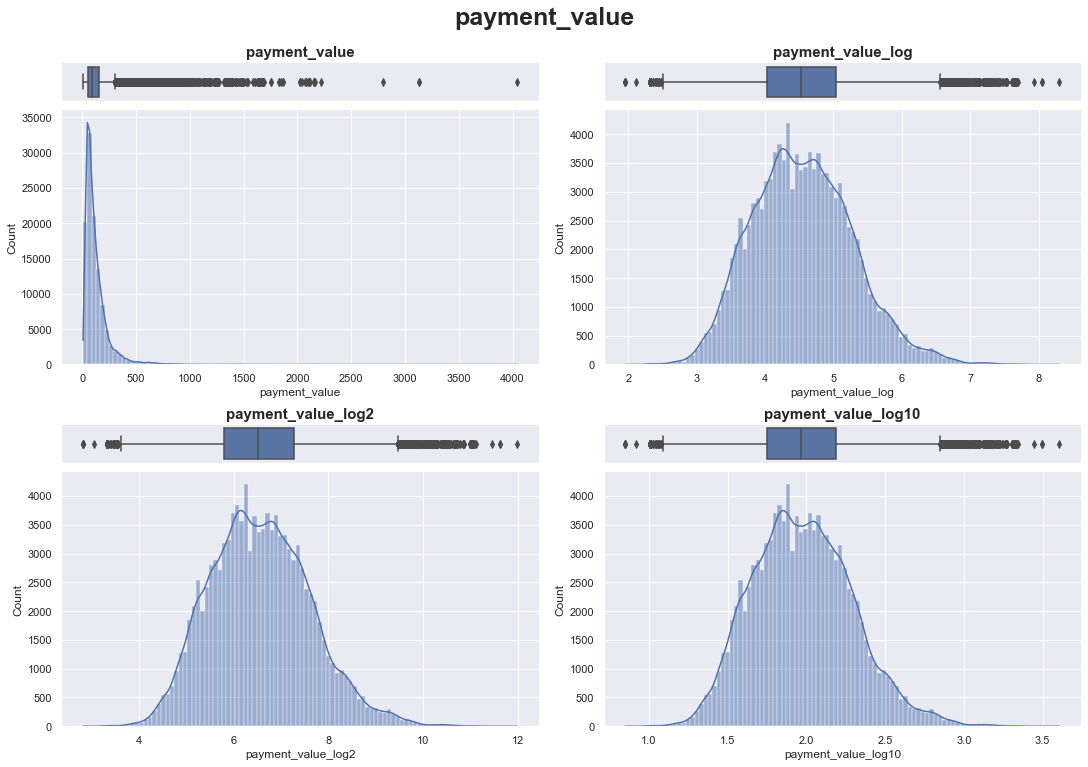


Variance of payment_value
------------------------------------


,variance
payment_value_log,0.534517
payment_value_log2,1.112528
payment_value_log10,0.100816


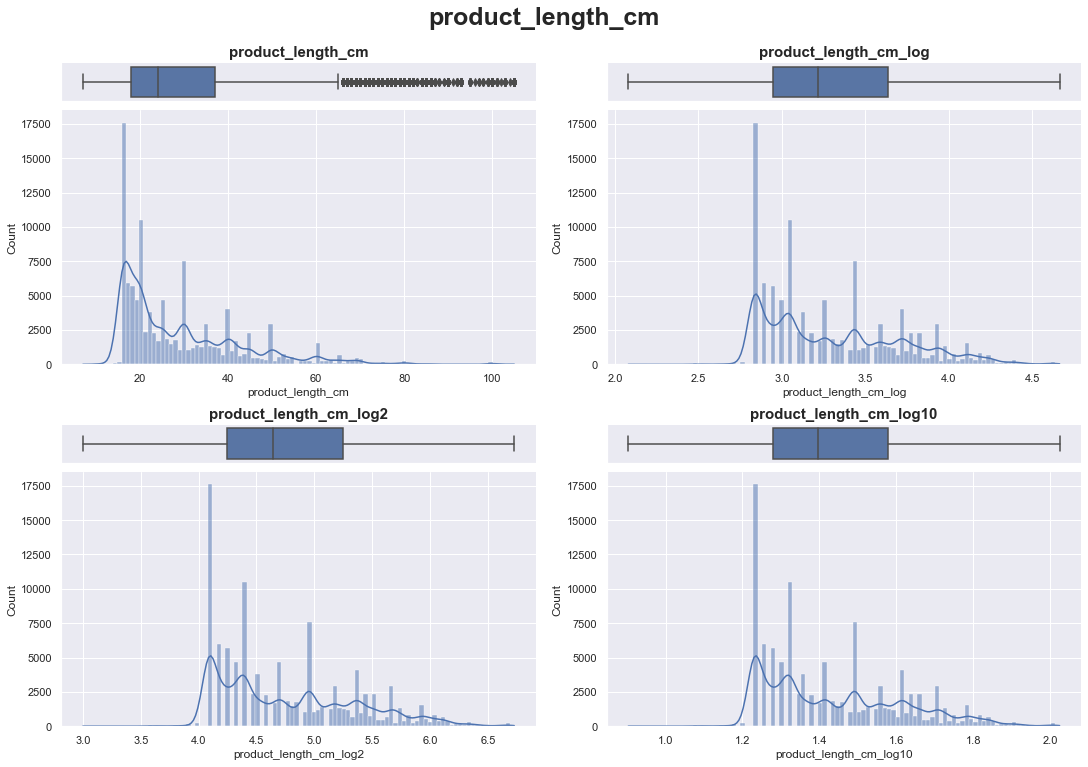


Variance of product_length_cm
------------------------------------


,variance
product_length_cm_log,0.176733
product_length_cm_log2,0.367848
product_length_cm_log10,0.033334


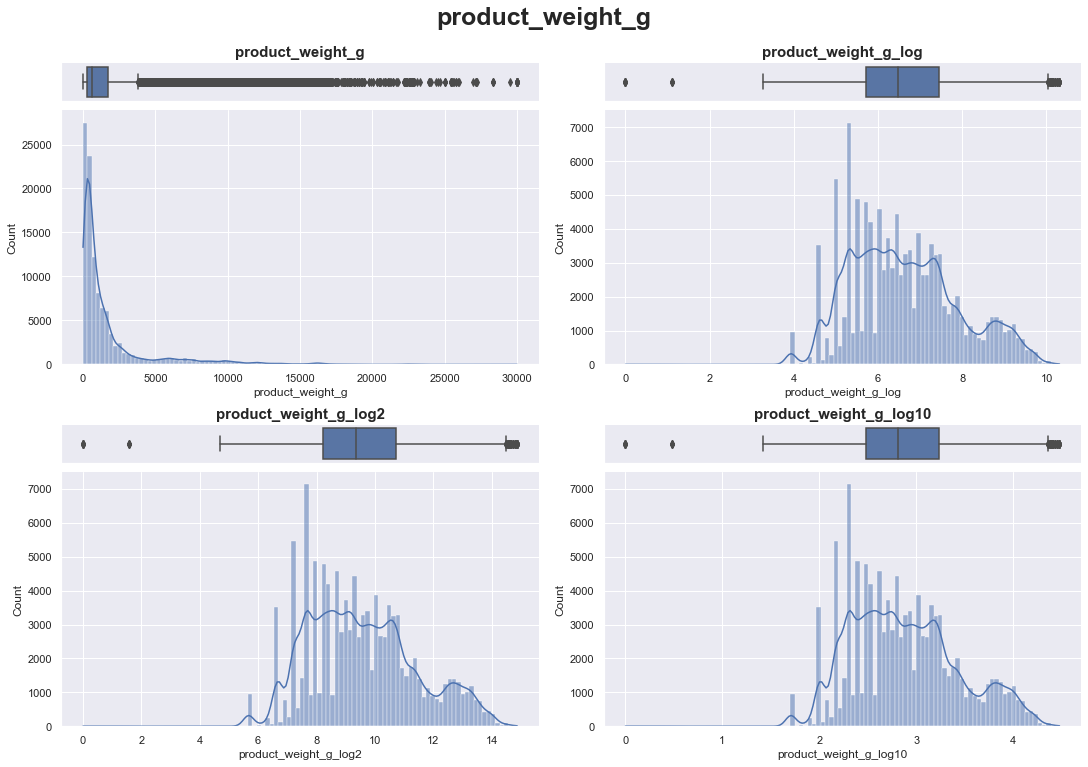


Variance of product_weight_g
------------------------------------


,variance
product_weight_g_log,1.621854
product_weight_g_log2,3.375677
product_weight_g_log10,0.305901


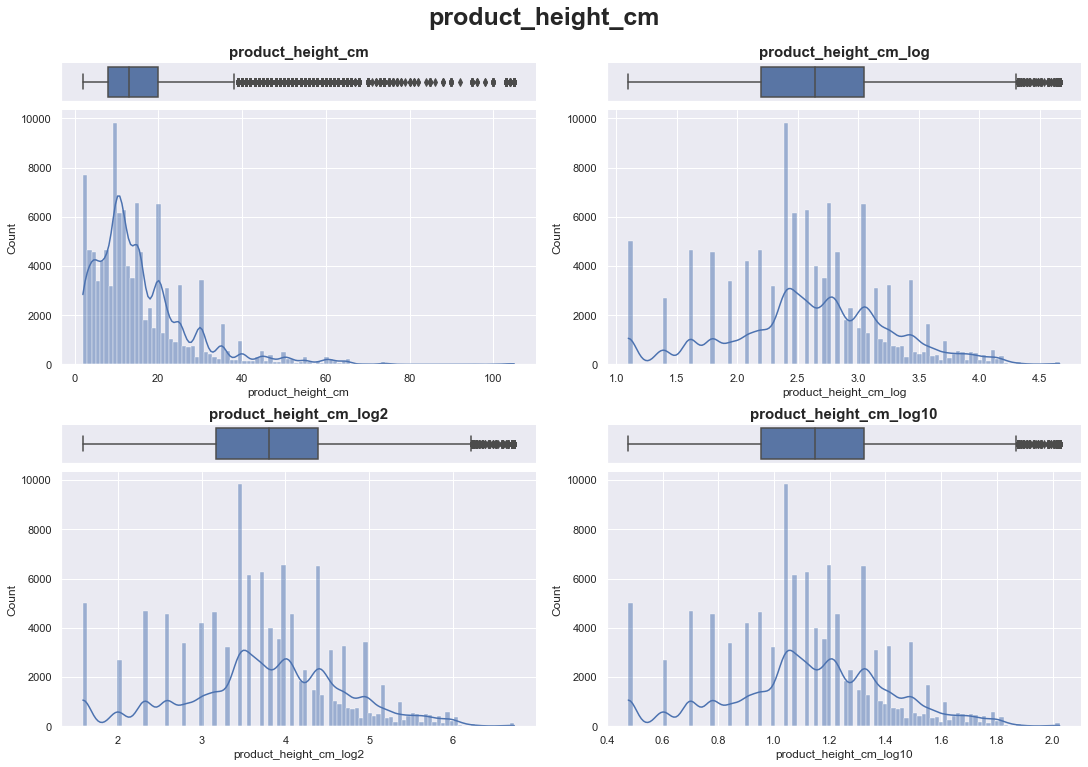


Variance of product_height_cm
------------------------------------


,variance
product_height_cm_log,0.466562
product_height_cm_log2,0.971088
product_height_cm_log10,0.087999


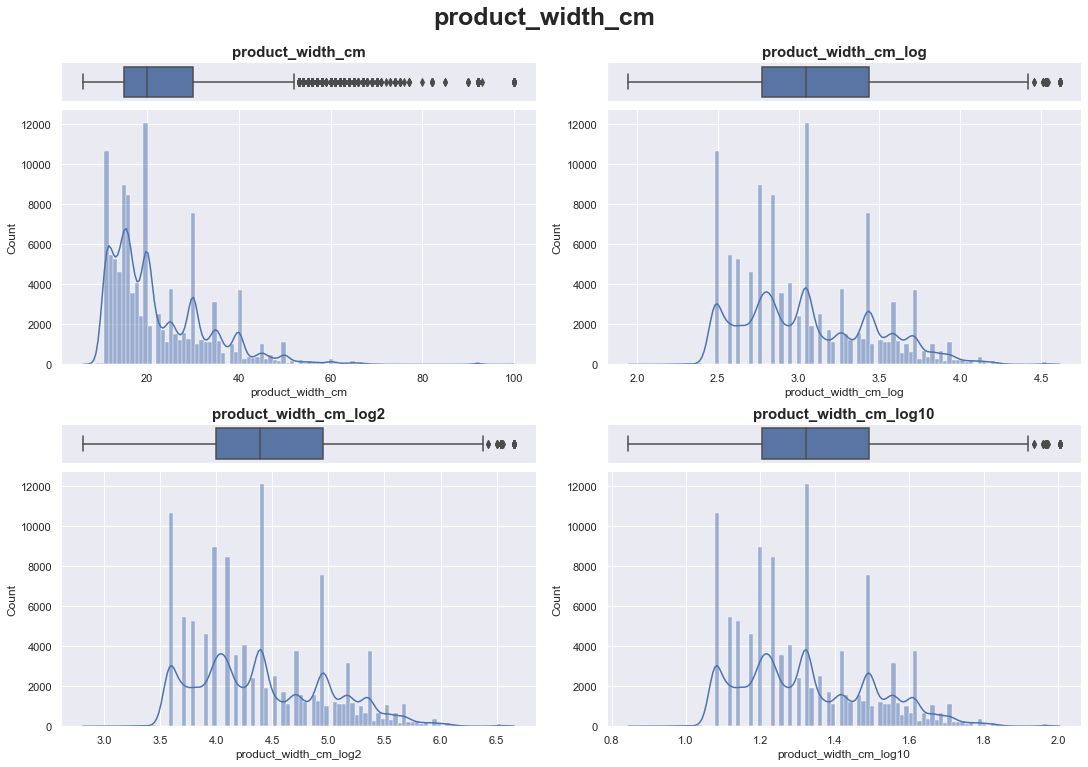


Variance of product_width_cm
------------------------------------


,variance
product_width_cm_log,0.172975
product_width_cm_log2,0.360025
product_width_cm_log10,0.032625


In [116]:
for var in NUMERIC_COLS:
    
    # We are going to work only with the rows without missing-values for the features
    df_subset = pd.DataFrame(data_outliers[data_outliers[[col]].notnull().all(axis=1)]).reset_index(drop=True)
    
    var_cols = [var + "", var + "_log", var + "_log2", var + "_log10"]
    
    fig = plt.figure(constrained_layout=True, figsize=[15,10])
    fig.suptitle(var, size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(ncols=2, nrows=4, width_ratios=[1,1], height_ratios=[0.3,2,0.3,2])
    
    # to cycle through the columns 
    col_boxplot, col_histplot = 0, 0
    
    for i in range(4):
        
        for j in range(2):
            
            if i % 2 == 0:
                
                if col_boxplot > len(var_cols) - 1:
                    break
                    
                ax_box = fig.add_subplot(spec[i, j])
                boxplot = sns.boxplot(data=data_outliers, x=var_cols[col_boxplot], ax=ax_box)
                
                # Remove x axis name for the boxplot
                ax_box.set(xlabel="", xticks=[])
                ax_box.set(yticks=[])
                
                boxplot.set_title(var_cols[col_boxplot], fontdict={ "fontsize": 15, "fontweight": "bold" })
                
                col_boxplot += 1
                
            elif i % 2 != 0:
                
#                 if col_histplot > len(NUMERIC_COLS):
#                     break
                    
                ax_hist = fig.add_subplot(spec[i, j])
                sns.histplot(data=data_outliers, x=var_cols[col_histplot], bins=100,  kde=True,  ax=ax_hist)
                ax_hist.set(xlabel=var_cols[col_histplot])
                
                col_histplot += 1
    
    plt.savefig("images/transformation-" + var + ".png", bbox_inches="tight")
    sns.despine(fig)  
    plt.show()
    
    print("\nVariance of", var)
    print("------------------------------------")
    var_cols.remove(var)
    df_temp = pd.DataFrame(data_outliers[var_cols].var(), columns=["variance"])
    display(df_temp.style.apply(highlight_max))
    print("\n")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Based on the description of data and distribution plot before and after transformation, we can say that we are going to work with <b>log_2</b> because is the <b>highest variance</b></p>
</div>

<div class="alert alert-block alert-info">
     Deleting the columns differents to "_log2" and ordering columns
</div>

In [117]:
for col in NUMERIC_COLS:
    data_outliers[col + "_log"] = np.log(data_outliers[col] + 1)
    data_outliers[col + "_log2"] = np.log2(data_outliers[col] + 1)
    data_outliers[col + "_log10"] = np.log10(data_outliers[col] + 1)

In [118]:
for col in NUMERIC_COLS:
    data_outliers.drop(columns=[col, col + "_log", col + "_log10"], inplace=True)

In [119]:
df_analysis(data_outliers, "data_outliers", type_analysis="complete")


Analysis of data_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 14 columns
- Total of NaN values:            15616
- Percentage of NaN:              0.98 %
- Total of full duplicates rows:  10454
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 13.5+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,113425,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,113425,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_status,category,113425,8,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_purchase_timestamp,datetime64[ns],113425,98875,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,review_score,float64,113425,11,0,0.00000,4.00035,1.00000,3.00000,5.00000,5.00000,5.00000,1.41067
6,customer_city,category,113425,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,customer_state,category,113425,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,customer_region,category,113425,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,product_width_cm_log2,float64,111204,79,2221,1.96000,4.42671,2.80735,4.00000,4.39232,4.95420,6.65821,0.60002
12,product_height_cm_log2,float64,111116,93,2309,2.04000,3.76241,1.58496,3.16993,3.80735,4.39232,6.72792,0.98544


In [120]:
data_outliers.rename(columns={"product_width_cm_log2":"product_width_cm", "product_height_cm_log2":"product_height_cm",
                             "payment_value_log2":"payment_value", "product_length_cm_log2":"product_length_cm",
                             "product_weight_g_log2":"product_weight_g"}, inplace=True)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">7. Treating missing-values</h2>
</div>

<div class="alert alert-block alert-info">
    <p><b>To treat missing-values</b>, we are going to do as follows</p>
    <ol>
        <li>Fill missing-vallues in <b>product_category</b> with a fake value <b>(unknown)</b>.</li>
        <li>Fill missing-vallues <b>numerical features</b> through <b>imputers</b>.</li>
    </ol>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.1. Missing-values in Product category</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Next, we are going to start to treat missing values in <b>product_category</b></p>
    <p>We make sure that add the new category before treating missing-values</p>
</div>

In [121]:
data_outliers["product_category"] = data_outliers["product_category"].cat.add_categories("unknown")

In [122]:
data_outliers["product_category"] = data_outliers["product_category"].fillna("unknown")

In [123]:
df_analysis(data_outliers, "data_outliers")


Analysis of data_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 14 columns
- Total of NaN values:            13238
- Percentage of NaN:              0.83 %
- Total of full duplicates rows:  10454
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 13.5+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,order_id,object,113425,0,0.00000
1,customer_unique_id,object,113425,0,0.00000
2,order_status,category,113425,0,0.00000
3,order_purchase_timestamp,datetime64[ns],113425,0,0.00000
4,review_score,float64,113425,0,0.00000
5,product_category,category,113425,0,0.00000
6,customer_city,category,113425,0,0.00000
7,customer_state,category,113425,0,0.00000
8,customer_region,category,113425,0,0.00000
13,product_width_cm,float64,111204,2221,1.96000


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.2. Train/Test split</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are not consider the feature  <b>order_purchase_timestamp</b></p>
</div>

In [124]:
df_subset = pd.DataFrame(data_outliers[data_outliers.notnull().all(axis=1)]).reset_index(drop=True)
df_subset.drop(columns=["order_purchase_timestamp"], axis=1, inplace=True)

In [125]:
df_analysis(df_subset, "df_subset")


Analysis of df_subset dataset
--------------------------------------------------------------------
- Dataset shape:                  105412 rows and 13 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  9880
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 7.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,order_id,object,105412,0,0.00000
1,customer_unique_id,object,105412,0,0.00000
2,order_status,category,105412,0,0.00000
3,review_score,float64,105412,0,0.00000
4,product_category,category,105412,0,0.00000
5,customer_city,category,105412,0,0.00000
6,customer_state,category,105412,0,0.00000
7,customer_region,category,105412,0,0.00000
8,payment_value,float64,105412,0,0.00000
9,product_length_cm,float64,105412,0,0.00000


<div class="alert alert-block alert-info">
    <b>Slipt</b> the dataset into <b>train</b> and <b>test</b>.</br> We are goint to work with the configuration below
    <ul style="list-style-type: square;">
        <li>Spliting the dataset without missing-values into <b>70% training dataset</b> and <b>30% testing dataset</b></li>
        <li>Create a <b>copy</b> dataset based on <b>testing dataset</b></li>
        <li><b>To assign NaN 90%</b> of data for <b>product_category</b> and <b>payment_value_log2</b> columns in the <b>copy</b> dataset based on <b>testing dataset</b></li>
        <li><b>Concatenating</b> the <b>training dataset</b> with <b>testing dataset (with 100% of NaN in testing dataset)</b> to make the <b>transform()</b></li>
    </ul>
</div>

In [126]:
test_features_nan = {
    "payment_value" : "payment_value", "product_length" : "product_length_cm", 
    "product_weight" : "product_weight_g", "product_height" : "product_height_cm",
    "product_width" : "product_width_cm"
}

In [127]:
for item in test_features_nan.keys():
    globals()["train_" + item], globals()["test_" + item] = train_test_split(df_subset, test_size=0.3, random_state=0)
    globals()["test_NaN_" + item] = globals()["test_" + item].loc[:]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.3. Data preprocessing</h3>
</div>

In [128]:
le = LabelEncoder()
scaler = StandardScaler()

In [129]:
for item in test_features_nan.keys():
    
    for df_type in ["train_", "test_", "test_NaN_"]:
        
        # Making LabelEncoder on categorical columns
        df_le = globals()[df_type + item][["order_id", "order_status", "customer_unique_id", "product_category", 
                                           "customer_city", "customer_state", "customer_region"]].copy().apply(le.fit_transform)
        
        # Droping the real columns and concatenating the encoder columns
        globals()[df_type + item] = globals()[df_type + item].drop(columns=["order_id", "order_status", "customer_unique_id", "order_status", 
                                                                            "product_category", "customer_city", "customer_state", 
                                                                            "customer_region"], axis=1)
        
        globals()[df_type + item] = pd.concat([globals()[df_type + item], df_le], axis=1)
        
        # Normalizing the datesets
        scaler_features = scaler.fit_transform(globals()[df_type + item])
        globals()[df_type + item + "_scaled"] = pd.DataFrame(scaler_features, index=globals()[df_type + item].index, columns=globals()[df_type + item].columns)
        

<div class="alert alert-block alert-info">
    <p><b>To assign NaN 90%</b> of data for <b>product_category</b> and <b>payment_value_log2</b> columns in the <b>copy</b> dataset based on <b>testing dataset</b></p>
</div>

In [130]:
for item in test_features_nan.keys():
    globals()["test_NaN_" + item + "_scaled"][test_features_nan.get(item)] = globals()["test_NaN_" + item + "_scaled"][test_features_nan.get(item)].mask(np.random.random(globals()["test_NaN_" + item + "_scaled"].shape[0]) < 0.99)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.3. Make imputations</h3>
</div>

In [131]:
for item in test_features_nan.keys():
    
    globals()["test_" + item].loc[:, ["data_origin"]] = "Original"
    
    for impute in ["SimpleImputer", "KNNImputer", "IterativeImputer"]:
        
        # Making the imputations by each impute
        globals()["result_" + item + "_" + impute] = df_imputations(globals()["train_" + item + "_scaled"], globals()["test_NaN_" + item + "_scaled"], impute, scaler)
        globals()["result_" + item + "_" + impute].loc[:, ["data_origin"]] = impute
        
         # Concatenating the results to compare
        globals()["test_" + item] = pd.concat([globals()["test_" + item], globals()["result_" + item + "_" + impute]])

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.4. Calculating the Root Mean Square Error</h3>
</div>

In [132]:
LIST_METHOD, LIST_FEATURE, LIST_RMSE = [list() for i in range(3)]

for item in test_features_nan.keys():
    
    for data_origin in globals()["test_" + item]["data_origin"].unique():
        
        if data_origin != "Original":
            
            # Calculating MSE for each feature
            MSE = mean_squared_error((globals()["test_" + item].loc[globals()["test_" + item]["data_origin"] == "Original", test_features_nan.get(item)]), \
                                 (globals()["test_" + item].loc[globals()["test_" + item]["data_origin"] == data_origin, test_features_nan.get(item)]))
            
            # Calculating RMSE for each feature
            RMSE = round(math.sqrt(MSE), 2)
            
            LIST_FEATURE.append(test_features_nan.get(item))
            LIST_METHOD.append(data_origin)
            LIST_RMSE.append(RMSE)
            
            
df_RMSE = pd.DataFrame({
    "Feature" : LIST_FEATURE,
    "Method" : LIST_METHOD,
    "RMSE" : LIST_RMSE
})

df_RMSE

,Feature,Method,RMSE
0,payment_value,SimpleImputer,1.04
1,payment_value,KNNImputer,0.85
2,payment_value,IterativeImputer,0.89
3,product_length_cm,SimpleImputer,0.60
4,product_length_cm,KNNImputer,0.38
5,product_length_cm,IterativeImputer,0.43
6,product_weight_g,SimpleImputer,1.81
7,product_weight_g,KNNImputer,1.02
8,product_weight_g,IterativeImputer,1.08
9,product_height_cm,SimpleImputer,0.98


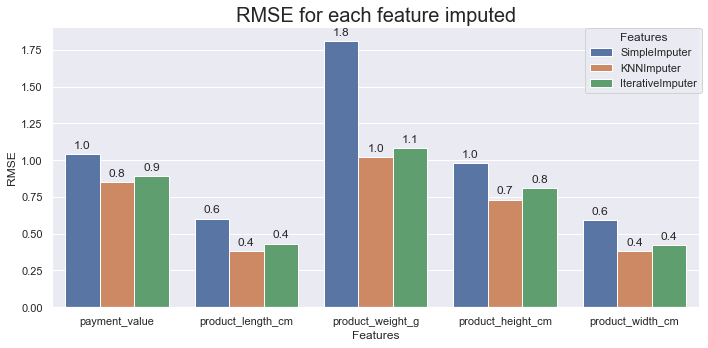

In [133]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title("RMSE for each feature imputed", size=20)
plot = sns.barplot(x="Feature", y="RMSE", hue="Method", data=df_RMSE, ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.legend(bbox_to_anchor=(1.004, 1), borderaxespad=0, title="Features")
plt.tight_layout()
plt.xlabel("Features", size=12)
plt.ylabel("RMSE", size=12)
plt.savefig("images/missing-values-imputations-RMSE.png")
sns.despine(fig)

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br><br>
    The <b>KNNImputer</b> is the best result
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.5. Making final imputations</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are not consider the feature  <b>order_purchase_timestamp</b></p>
    <p>Making a <b>mask</b> to filter the records <b>without missing-values</b> to use them to fit the <b>KNN Imputer</b></p>
</div>

In [134]:
df_to_impute_KNN = data_outliers.loc[:]

In [135]:
df_to_impute_KNN.drop(columns=["order_purchase_timestamp"], axis=1, inplace=True)

In [136]:
mask = df_to_impute_KNN[["product_width_cm", "product_height_cm", "payment_value", "product_length_cm", "product_weight_g"]].notnull().all(axis=1)

In [137]:
df_trainnig = df_to_impute_KNN[mask].loc[:]

In [138]:
df_analysis(df_trainnig, "df_trainnig")


Analysis of df_trainnig dataset
--------------------------------------------------------------------
- Dataset shape:                  105412 rows and 13 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  9880
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 8.0+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,order_id,object,105412,0,0.00000
1,customer_unique_id,object,105412,0,0.00000
2,order_status,category,105412,0,0.00000
3,review_score,float64,105412,0,0.00000
4,product_category,category,105412,0,0.00000
5,customer_city,category,105412,0,0.00000
6,customer_state,category,105412,0,0.00000
7,customer_region,category,105412,0,0.00000
8,payment_value,float64,105412,0,0.00000
9,product_length_cm,float64,105412,0,0.00000


<div class="alert alert-block alert-info">
    Preprocessing all data
</div>

In [139]:
le = LabelEncoder()
scaler = StandardScaler()

In [140]:
for df in ["df_trainnig", "df_to_impute_KNN"]:
    
    # Making LabelEncoder on categorical columns
    df_le = globals()[df][["order_id", "order_status", "customer_unique_id", "product_category", 
                     "customer_city", "customer_state", "customer_region"]].copy().apply(le.fit_transform)
    
    # Droping the real columns and concatenating the encoder columns
    globals()[df] = globals()[df].drop(columns=["order_id", "order_status", "customer_unique_id", "order_status", 
                                                "product_category", "customer_city", "customer_state", "customer_region"], axis=1)
    
    globals()[df] = pd.concat([globals()[df], df_le], axis=1)
    
    # Normalizing the datesets
    scaler_features = scaler.fit_transform(globals()[df])
    globals()[df] = pd.DataFrame(scaler_features, index=globals()[df].index, columns=globals()[df].columns)    

<div class="alert alert-block alert-info">
    Making the imputation
</div>

In [141]:
df_imputed = df_imputations(df_trainnig, df_to_impute_KNN, "KNNImputer", scaler)

<div class="alert alert-block alert-info">
    Refactoring the dataframe as original
</div>

In [142]:
df_imputed.drop(columns=["order_id", "order_status", "customer_unique_id", "product_category", 
                     "customer_city", "customer_state", "customer_region"], axis=1, inplace=True)

In [143]:
df_imputed = pd.concat([df_imputed, 
                        data_outliers[["order_id", "customer_unique_id", "order_status", "order_purchase_timestamp", 
                                       "product_category", "customer_city", "customer_state", "customer_region"]]], 
                       axis=1)

In [144]:
df_imputed.head()

,review_score,payment_value,product_length_cm,product_weight_g,product_height_cm,product_width_cm,order_id,customer_unique_id,order_status,order_purchase_timestamp,product_category,customer_city,customer_state,customer_region
69370,1.0,7.263347,4.802189,9.045916,4.500611,4.735688,10a045cdf6a5650c21e9cfeb60384c16,87ab9fec999db8bd5774917de3cdf01c,canceled,2018-10-17 17:30:18,unknown,sorocaba,SP,Southeast
77917,5.0,7.425433,4.834822,9.883990,4.830934,4.845703,b059ee4de278302d550a3035c4cdb740,262e1f1e26e92e86375f86840b4ffd63,canceled,2018-10-16 20:16:02,unknown,picos,PI,Northeast
36374,1.0,6.621083,4.727979,7.744666,3.948808,4.237344,a2ac6dad85cf8af5b0afb510a240fe8c,af5454198a97379394cacf676e1e96cb,canceled,2018-10-03 18:55:29,unknown,registro,SP,Southeast
100823,2.0,7.322300,5.080981,10.585646,4.449298,4.675447,616fa7d4871b87832197b2a137a115d2,634420a0ea42302205032ed44ac7fccc,canceled,2018-10-01 15:30:09,unknown,pirai,RJ,Southeast
57391,1.0,6.856240,4.522920,9.365564,3.394815,4.148414,392ed9afd714e3c74767d0c4d3e3f477,9bb92bebd4cb7511e1a02d5e50bc4655,canceled,2018-09-29 09:13:03,unknown,guarulhos,SP,Southeast


In [145]:
df_imputed = df_imputed[["order_id", "customer_unique_id", "order_purchase_timestamp", 
                         "order_status", "review_score", "payment_value", "product_category", 
                         "product_length_cm", "product_weight_g", "product_height_cm", 
                         "product_width_cm", "customer_city", "customer_state", "customer_region"]]

In [146]:
df_analysis(df_imputed, "df_imputed")


Analysis of df_imputed dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 14 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  10454
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 13.5+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,order_id,object,113425,0,0.00000
1,customer_unique_id,object,113425,0,0.00000
2,order_purchase_timestamp,datetime64[ns],113425,0,0.00000
3,order_status,category,113425,0,0.00000
4,review_score,float64,113425,0,0.00000
5,payment_value,float64,113425,0,0.00000
6,product_category,category,113425,0,0.00000
7,product_length_cm,float64,113425,0,0.00000
8,product_weight_g,float64,113425,0,0.00000
9,product_height_cm,float64,113425,0,0.00000


In [147]:
df_imputed.head()

,order_id,customer_unique_id,order_purchase_timestamp,order_status,review_score,payment_value,product_category,product_length_cm,product_weight_g,product_height_cm,product_width_cm,customer_city,customer_state,customer_region
69370,10a045cdf6a5650c21e9cfeb60384c16,87ab9fec999db8bd5774917de3cdf01c,2018-10-17 17:30:18,canceled,1.0,7.263347,unknown,4.802189,9.045916,4.500611,4.735688,sorocaba,SP,Southeast
77917,b059ee4de278302d550a3035c4cdb740,262e1f1e26e92e86375f86840b4ffd63,2018-10-16 20:16:02,canceled,5.0,7.425433,unknown,4.834822,9.883990,4.830934,4.845703,picos,PI,Northeast
36374,a2ac6dad85cf8af5b0afb510a240fe8c,af5454198a97379394cacf676e1e96cb,2018-10-03 18:55:29,canceled,1.0,6.621083,unknown,4.727979,7.744666,3.948808,4.237344,registro,SP,Southeast
100823,616fa7d4871b87832197b2a137a115d2,634420a0ea42302205032ed44ac7fccc,2018-10-01 15:30:09,canceled,2.0,7.322300,unknown,5.080981,10.585646,4.449298,4.675447,pirai,RJ,Southeast
57391,392ed9afd714e3c74767d0c4d3e3f477,9bb92bebd4cb7511e1a02d5e50bc4655,2018-09-29 09:13:03,canceled,1.0,6.856240,unknown,4.522920,9.365564,3.394815,4.148414,guarulhos,SP,Southeast


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>At this point, we get the dataset without missing-values</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">8. Adding / Transforming features</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.1. Purchase time</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Based on the purchase time, we are going to add new features</p>
</div>

In [148]:
df_imputed["purchase_year"] = data["order_purchase_timestamp"].map(lambda d: d.year)
df_imputed["purchase_month"] = data["order_purchase_timestamp"].map(lambda d: d.month)
df_imputed["purchase_weekday"] = data["order_purchase_timestamp"].map(lambda d: d.dayofweek)
df_imputed["purchase_day"] = data["order_purchase_timestamp"].map(lambda d: d.day)
df_imputed["purchase_hour"] = data["order_purchase_timestamp"].map(lambda d: d.hour)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.2. product dimensions</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Based on the product dimensions, we are going to add a new feature</p>
</div>

In [149]:
df_imputed["product_volume_cc"] = df_imputed["product_length_cm"] * df_imputed["product_height_cm"] * df_imputed["product_width_cm"] 

In [150]:
df_imputed.drop(columns=["product_length_cm","product_height_cm","product_width_cm"], axis=1, inplace=True)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.3. product category</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to analyse the <b>product_category</b> to get new information based on it</p>
    <p>To do that, we are going to follow the steps belows:</p>
    <ul style="list-style-type: square;">
        <li>Identify the categories with the greater sales</li>
        <li>Get the total payments values by customer</li>
        <li>Get the payments values by customer by category</li>
        <li>Calculate the weight of categories with the greater sales in the payments values by customer</li>
    </ul>
</div>

In [151]:
df_total_value_sales_by_category = df_imputed.groupby(["product_category"]).agg({"payment_value": "sum"}).reset_index()

In [152]:
df_total_value_sales_by_category.rename(columns={"payment_value" : "total_sales"}, inplace=True)

In [153]:
df_total_value_sales_by_category = df_total_value_sales_by_category.sort_values("total_sales", ascending=False).reset_index()

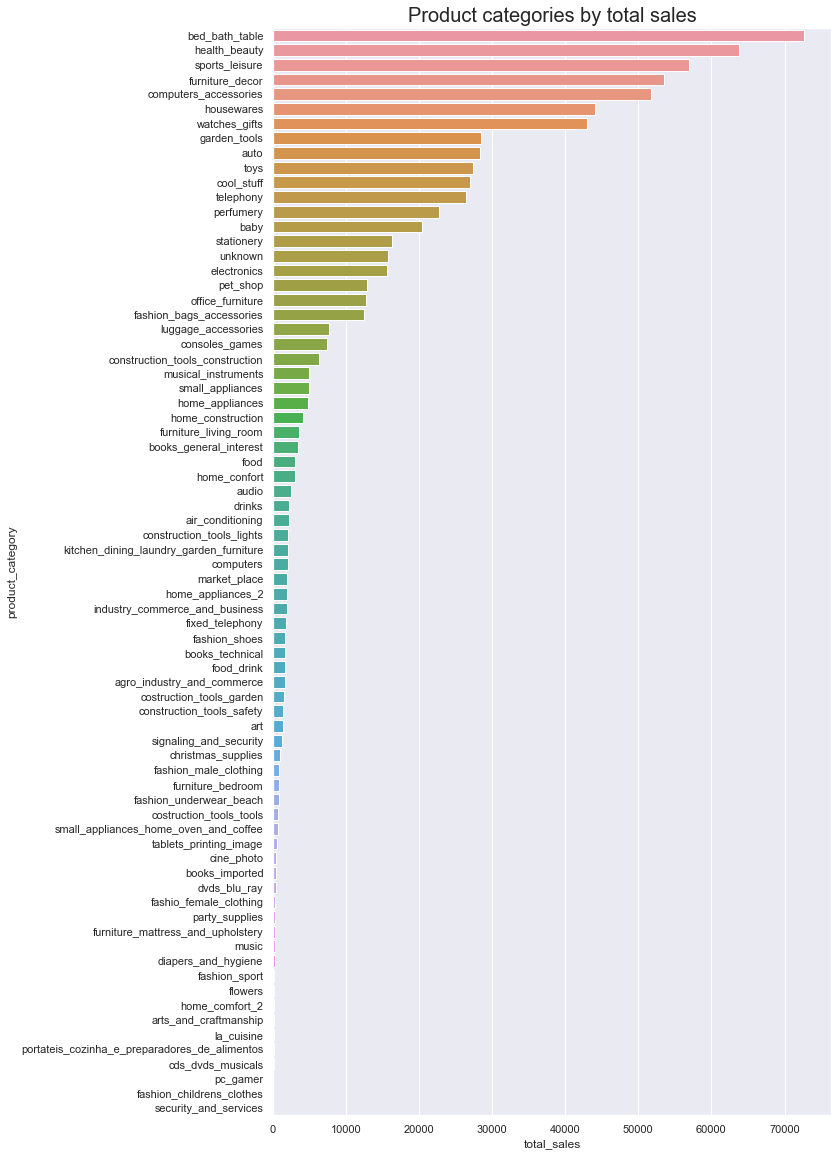

In [154]:
plt.figure(figsize=(10, 20))
sns.barplot(y="product_category", 
            x="total_sales", 
            data=df_total_value_sales_by_category, 
            order=df_total_value_sales_by_category["product_category"])
plt.title("Product categories by total sales", size=20)
plot.set(xlabel="Total sales", ylabel="Product categories")
plt.savefig("images/product-categories-by-total-sales.png")
sns.despine(fig)
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>We are going to select <b>the 10 categories with greater sales</b> to transform them as features</p>
</div>

In [155]:
LIST_CATEGORIES_AS_FEATURE = df_total_value_sales_by_category["product_category"].head(10).to_list()
LIST_CATEGORIES_AS_FEATURE

['bed_bath_table',
 'health_beauty',
 'sports_leisure',
 'furniture_decor',
 'computers_accessories',
 'housewares',
 'watches_gifts',
 'garden_tools',
 'auto',
 'toys']

<div class="alert alert-block alert-info">
    <p>Now, let's identify <b>the payments values by customer by categories</b></p>
</div>

In [156]:
df_payments_value_by_customer_by_category = df_imputed.groupby(["customer_unique_id", "product_category"]).agg({
                                            "payment_value": "sum"
                                            }).sort_values("payment_value", ascending=False).sort_values("customer_unique_id", ascending=True).reset_index()
df_payments_value_by_customer_by_category.head(15)

,customer_unique_id,product_category,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,flowers,0.0
1,0000366f3b9a7992bf8c76cfdf3221e2,fashion_shoes,0.0
2,0000366f3b9a7992bf8c76cfdf3221e2,fashion_male_clothing,0.0
3,0000366f3b9a7992bf8c76cfdf3221e2,perfumery,0.0
4,0000366f3b9a7992bf8c76cfdf3221e2,pet_shop,0.0
5,0000366f3b9a7992bf8c76cfdf3221e2,portateis_cozinha_e_preparadores_de_alimentos,0.0
6,0000366f3b9a7992bf8c76cfdf3221e2,security_and_services,0.0
7,0000366f3b9a7992bf8c76cfdf3221e2,signaling_and_security,0.0
8,0000366f3b9a7992bf8c76cfdf3221e2,small_appliances,0.0
9,0000366f3b9a7992bf8c76cfdf3221e2,small_appliances_home_oven_and_coffee,0.0


<div class="alert alert-block alert-info">
    <p><b>Filtering</b> based on the <b>15 categories gith greater sales</b></p>
</div>

In [157]:
df_payments_value_by_customer_by_category = df_payments_value_by_customer_by_category.loc[df_payments_value_by_customer_by_category["product_category"].isin(LIST_CATEGORIES_AS_FEATURE)]

In [158]:
df_payments_value_by_customer_by_category["product_category"].unique()

['sports_leisure', 'toys', 'watches_gifts', 'housewares', 'health_beauty', 'garden_tools', 'furniture_decor', 'auto', 'bed_bath_table', 'computers_accessories']
Categories (10, object): ['sports_leisure', 'toys', 'watches_gifts', 'housewares', ..., 'furniture_decor', 'auto', 'bed_bath_table', 'computers_accessories']

In [159]:
df_payments_value_by_customer_by_category.head()

,customer_unique_id,product_category,payment_value
10,0000366f3b9a7992bf8c76cfdf3221e2,sports_leisure,0.0
14,0000366f3b9a7992bf8c76cfdf3221e2,toys,0.0
15,0000366f3b9a7992bf8c76cfdf3221e2,watches_gifts,0.0
25,0000366f3b9a7992bf8c76cfdf3221e2,housewares,0.0
31,0000366f3b9a7992bf8c76cfdf3221e2,health_beauty,0.0


<div class="alert alert-block alert-info">
    <p>Now, let's pivot the table</p>
</div>

In [160]:
df_payments_value_by_customer_by_category = pd.pivot_table(df_payments_value_by_customer_by_category, values="payment_value", index="customer_unique_id", columns="product_category")

In [161]:
df_payments_value_by_customer_by_category.head()

product_category,auto,bed_bath_table,computers_accessories,furniture_decor,garden_tools,health_beauty,housewares,sports_leisure,toys,watches_gifts
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,7.158862,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.000000,0.0,0.0,0.0,4.817112,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [162]:
df_payments_value_by_customer_by_category.columns

CategoricalIndex(['auto', 'bed_bath_table', 'computers_accessories',
                  'furniture_decor', 'garden_tools', 'health_beauty',
                  'housewares', 'sports_leisure', 'toys', 'watches_gifts'],
                 categories=['agro_industry_and_commerce', 'air_conditioning', 'art', 'arts_and_craftmanship', 'audio', 'auto', 'baby', 'bed_bath_table', ...], ordered=False, name='product_category', dtype='category')

In [163]:
df_payments_value_by_customer_by_category.columns = df_payments_value_by_customer_by_category.columns.add_categories(["customer_unique_id"])

In [164]:
df_payments_value_by_customer_by_category.columns = pd.Index(list(df_payments_value_by_customer_by_category.columns))

In [165]:
df_payments_value_by_customer_by_category.columns

Index(['auto', 'bed_bath_table', 'computers_accessories', 'furniture_decor',
       'garden_tools', 'health_beauty', 'housewares', 'sports_leisure', 'toys',
       'watches_gifts'],
      dtype='object')

In [166]:
df_payments_value_by_customer_by_category.head()

,auto,bed_bath_table,computers_accessories,furniture_decor,garden_tools,health_beauty,housewares,sports_leisure,toys,watches_gifts
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,7.158862,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.000000,0.0,0.0,0.0,4.817112,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [167]:
df_payments_value_by_customer_by_category.reset_index(inplace=True)

In [168]:
df_payments_value_by_customer_by_category.head()

,customer_unique_id,auto,bed_bath_table,computers_accessories,furniture_decor,garden_tools,health_beauty,housewares,sports_leisure,toys,watches_gifts
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,7.158862,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.000000,0.0,0.0,0.0,4.817112,0.0,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


<div class="alert alert-block alert-info">
    <p>Now, let's identify <b>the total payments values by customer</b></p>
</div>

In [169]:
df_total_payments_value_by_customer = df_imputed.groupby(["customer_unique_id"]).agg({
                                "payment_value": "sum"
                                }).sort_values("payment_value", ascending=False).reset_index()

df_total_payments_value_by_customer.rename(columns={"payment_value":"total_payments_value"}, inplace=True)

df_total_payments_value_by_customer

,customer_unique_id,total_payments_value
0,c8460e4251689ba205045f3ea17884a1,182.515566
1,698e1cf81d01a3d389d96145f7fa6df8,136.693213
2,c402f431464c72e27330a67f7b94d4fb,135.919494
3,0f5ac8d5c31de21d2f25e24be15bbffb,115.789995
4,eae0a83d752b1dd32697e0e7b4221656,111.861922
...,...,...
96091,6f5b9d1cdccc4d28f0483a612edecacf,3.658783
96092,2878e5b88167faab17d4fb83a986d38b,3.658783
96093,b33336f46234b24a613ad9064d13106d,3.571677
96094,bd06ce0e06ad77a7f681f1a4960a3cc6,3.468583


<div class="alert alert-block alert-info">
    <p>Let's concatenate the two datasets</p>
</div>

In [170]:
df_details_payments_by_customer = df_payments_value_by_customer_by_category.merge(right=df_total_payments_value_by_customer, on="customer_unique_id", how="left")

In [171]:
df_details_payments_by_customer.head(10)

,customer_unique_id,auto,bed_bath_table,computers_accessories,furniture_decor,garden_tools,health_beauty,housewares,sports_leisure,toys,watches_gifts,total_payments_value
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,7.158862,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,7.158862
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.000000,0.0,0.0,0.000000,4.817112,0.0,0.000000,0.0,0.0,4.817112
2,0000f46a3911fa3c0805444483337064,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,6.446587
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,5.479619
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,7.628555
5,0004bd2a26a76fe21f786e4fbd80607f,0.0,0.000000,0.0,0.0,7.392146,0.000000,0.0,0.000000,0.0,0.0,7.392146
6,00050ab1314c0e55a6ca13cf7181fecf,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,5.185074
7,00053a61a98854899e70ed204dd4bafe,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,15.436586,0.0,0.0,15.436586
8,0005e1862207bf6ccc02e4228effd9a0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,7.239551
9,0005ef4cd20d2893f0d9fbd94d3c0d97,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,7.030777,0.0,0.0,7.030777


<div class="alert alert-block alert-info">
    <p>Now, let's calculate the weight of each category with respect to total_payments_values</p>
</div>

In [172]:
df_weight_details_payments_by_customer = df_details_payments_by_customer.copy()

In [173]:
for col in df_weight_details_payments_by_customer.columns:
     if col != "total_payments_value" and col != "customer_unique_id":
            df_weight_details_payments_by_customer[col] = df_weight_details_payments_by_customer[col] / df_weight_details_payments_by_customer["total_payments_value"] * 100

In [179]:
df_analysis(df_weight_details_payments_by_customer, "df_weight_details_payments_by_customer", type_analysis="complete")


Analysis of df_weight_details_payments_by_customer dataset
--------------------------------------------------------------------
- Dataset shape:                  96096 rows and 12 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 11.5+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,96096,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,auto,float64,96096,130,0,0.00000,3.93780,0.00000,0.00000,0.00000,0.00000,100.00000,19.36862
2,bed_bath_table,float64,96096,538,0,0.00000,9.22842,0.00000,0.00000,0.00000,0.00000,100.00000,28.70463
3,computers_accessories,float64,96096,216,0,0.00000,6.71054,0.00000,0.00000,0.00000,0.00000,100.00000,24.91531
4,furniture_decor,float64,96096,526,0,0.00000,6.29378,0.00000,0.00000,0.00000,0.00000,100.00000,24.01589
5,garden_tools,float64,96096,206,0,0.00000,3.52254,0.00000,0.00000,0.00000,0.00000,100.00000,18.29919
6,health_beauty,float64,96096,290,0,0.00000,8.87560,0.00000,0.00000,0.00000,0.00000,100.00000,28.31352
7,housewares,float64,96096,347,0,0.00000,5.86726,0.00000,0.00000,0.00000,0.00000,100.00000,23.32211
8,sports_leisure,float64,96096,304,0,0.00000,7.66001,0.00000,0.00000,0.00000,0.00000,100.00000,26.45486
9,toys,float64,96096,181,0,0.00000,3.90616,0.00000,0.00000,0.00000,0.00000,100.00000,19.25805


In [174]:
df_weight_details_payments_by_customer.loc[25:45,]

,customer_unique_id,auto,bed_bath_table,computers_accessories,furniture_decor,garden_tools,health_beauty,housewares,sports_leisure,toys,watches_gifts,total_payments_value
25,001147e649a7b1afd577e873841632dd,0.0,0.000000,0.000000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,13.485090
26,00115fc7123b5310cf6d3a3aa932699e,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,100.0,0.0,0.0,6.268846
27,0011805441c0d1b68b48002f1d005526,0.0,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.219846
28,0011857aff0e5871ce5eb429f21cdaf5,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.598648
29,0011c98589159d6149979563c504cb21,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.894090
30,0012929d977a8d7280bb277c1e5f589d,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,100.0,7.291401
31,0014a5a58da615f7b01a4f5e194bf5ea,0.0,0.000000,0.000000,0.0,0.0,100.0,0.0,0.0,0.0,0.0,6.655638
32,0015752e079902b12cd00b9b7596276b,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.526820
33,00172711b30d52eea8b313a7f2cced02,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.600214
34,00191a9719ef48ebb5860b130347bf33,0.0,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.903520


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Most of the customer are bought only one category of product</p>
    <p>Later, we are going to concatenate this dataset with the rest of information</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">9. RFM Analysis</h2>
</div>

In [219]:
df_analysis(df_imputed, "df_imputed", type_analysis="complete")


Analysis of df_imputed dataset
--------------------------------------------------------------------
- Dataset shape:                  113425 rows and 17 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  10454
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 16.1+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,order_id,object,113425,99441,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,customer_state,category,113425,27,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,purchase_hour,int64,113425,24,0,0.00000,14.74693,0.00000,11.00000,15.00000,19.00000,23.00000,5.31332
14,purchase_day,int64,113425,31,0,0.00000,15.55312,1.00000,8.00000,16.00000,23.00000,31.00000,8.66610
13,purchase_weekday,int64,113425,7,0,0.00000,2.74502,0.00000,1.00000,3.00000,4.00000,6.00000,1.96294
12,purchase_month,int64,113425,12,0,0.00000,6.03216,1.00000,3.00000,6.00000,8.00000,12.00000,3.23496
11,purchase_year,int64,113425,3,0,0.00000,2017.54014,2016.00000,2017.00000,2018.00000,2018.00000,2018.00000,0.50519
10,customer_region,category,113425,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,customer_city,category,113425,4119,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,customer_unique_id,object,113425,96096,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info">
    <p>To make the <b>RFM analysis</b>, we are only going to work with <b>data for the last year to avoid penalizing new customers</b> compared to the old ones</p>
</div>


In [218]:
print("Newest day in the dataset", df_imputed["order_purchase_timestamp"].max())
print("Oldest day in the dataset", df_imputed["order_purchase_timestamp"].min())

Newest day in the dataset 2018-10-17 17:30:18
Oldest day in the dataset 2016-09-04 21:15:19


In [263]:
star_date = df_imputed["order_purchase_timestamp"].max() - pd.DateOffset(years=1)
end_date = df_imputed["order_purchase_timestamp"].max()

print("star date:", star_date)
print("end date:", end_date)

star date: 2017-10-17 17:30:18
end date: 2018-10-17 17:30:18


In [279]:
df_imputed_last_year = df_imputed.loc[(df_imputed["order_purchase_timestamp"] >= star_date) & (df_imputed["order_purchase_timestamp"] <= end_date)].copy()

In [280]:
print("Newest day in the dataset", df_imputed_last_year["order_purchase_timestamp"].max())
print("Oldest day in the dataset", df_imputed_last_year["order_purchase_timestamp"].min())

Newest day in the dataset 2018-10-17 17:30:18
Oldest day in the dataset 2017-10-17 17:30:56


<div class="alert alert-block alert-info">
    <p>Now, we are going to make the <b>RFM Analysis</b> to define the customer behavior segmentation stands for <b>recency</b>, <b>frequency</b>, and <b>monetary value</b>.</p>
    <p>To do that, we are going to use the following features</p>
        <ul style="list-style-type: disc;">
            <li><b>order_purchase_timestamp :</b> Shows the purchase timestamp. <b>(recency)</b>.</li>
            <li><b>order_id :</b> unique identifier of the order. <b>(frequency)</b>.</li>
            <li><b>payment_value :</b> Transaction value. <b>(monetary value)</b>.</li>
            <li><b>review_score :</b> Customer score per order . <b>(satisfaction)</b>.</li>
        </ul>
    <p>Before making that, let's analyse in details the dataset that we have so now.</p>
</div>

In [281]:
df_imputed_last_year = df_imputed_last_year[["order_id", "customer_unique_id", "order_purchase_timestamp", "payment_value", "review_score"]]

In [282]:
df_imputed_last_year.head()

,order_id,customer_unique_id,order_purchase_timestamp,payment_value,review_score
69370,10a045cdf6a5650c21e9cfeb60384c16,87ab9fec999db8bd5774917de3cdf01c,2018-10-17 17:30:18,7.263347,1.0
77917,b059ee4de278302d550a3035c4cdb740,262e1f1e26e92e86375f86840b4ffd63,2018-10-16 20:16:02,7.425433,5.0
36374,a2ac6dad85cf8af5b0afb510a240fe8c,af5454198a97379394cacf676e1e96cb,2018-10-03 18:55:29,6.621083,1.0
100823,616fa7d4871b87832197b2a137a115d2,634420a0ea42302205032ed44ac7fccc,2018-10-01 15:30:09,7.322300,2.0
57391,392ed9afd714e3c74767d0c4d3e3f477,9bb92bebd4cb7511e1a02d5e50bc4655,2018-09-29 09:13:03,6.856240,1.0


In [283]:
mask = df_imputed_last_year.duplicated("order_id", keep=False)
df_imputed_last_year["duplicated"] = mask
df_imputed_last_year[df_imputed_last_year["duplicated"]==True].sort_values("order_id").head(6)

,order_id,customer_unique_id,order_purchase_timestamp,payment_value,review_score,duplicated
61488,0008288aa423d2a3f00fcb17cd7d8719,9e4159995424971423b98c4a8bc11529,2018-02-13 22:10:21,6.006074,5.0,True
61487,0008288aa423d2a3f00fcb17cd7d8719,9e4159995424971423b98c4a8bc11529,2018-02-13 22:10:21,6.006074,5.0,True
30742,001ab0a7578dd66cd4b0a71f5b6e1e41,d1f24d1d504e27bee13b415e40daeab0,2017-12-27 00:38:47,5.443607,4.0,True
30744,001ab0a7578dd66cd4b0a71f5b6e1e41,d1f24d1d504e27bee13b415e40daeab0,2017-12-27 00:38:47,5.443607,4.0,True
30743,001ab0a7578dd66cd4b0a71f5b6e1e41,d1f24d1d504e27bee13b415e40daeab0,2017-12-27 00:38:47,5.443607,4.0,True
63385,002c9def9c9b951b1bec6d50753c9891,6bcc1cd0c7f8bffa6f67a6a1fbef5782,2018-05-14 16:57:47,6.457791,4.0,True


<div class="alert alert-block alert-warning">
    <p>As we can see, there is more than one row per order</p>
    <p>We need to have only one row per order so, we have to summarize the items in the order based on RFM needs</p>
</div>

<div class="alert alert-block alert-info">
    <p>Let's summarize the payments value per order.</p>
</div>

In [284]:
payments_values_per_order = df_imputed_last_year.groupby(["order_id"]).agg({
                                "payment_value": "sum"
                                }).reset_index()

In [285]:
df_imputed_last_year = df_imputed_last_year.merge(payments_values_per_order, on="order_id", how="left")

In [286]:
df_imputed_last_year.drop_duplicates("order_id", keep="first", inplace=True)

In [287]:
df_imputed_last_year[df_imputed_last_year["duplicated"]==True].sort_values("order_id").head(6)

,order_id,customer_unique_id,order_purchase_timestamp,payment_value_x,review_score,duplicated,payment_value_y
66819,0008288aa423d2a3f00fcb17cd7d8719,9e4159995424971423b98c4a8bc11529,2018-02-13 22:10:21,6.006074,5.0,True,12.012147
71974,001ab0a7578dd66cd4b0a71f5b6e1e41,d1f24d1d504e27bee13b415e40daeab0,2017-12-27 00:38:47,5.443607,4.0,True,16.330820
48631,002c9def9c9b951b1bec6d50753c9891,6bcc1cd0c7f8bffa6f67a6a1fbef5782,2018-05-14 16:57:47,6.457791,4.0,True,12.915583
63556,003822434f91204da0a51fe4cf2aba18,250b38e3586d512ece3671470c5d5f6d,2018-06-13 14:10:54,6.468909,5.0,True,12.937818
4975,003f201cdd39cdd59b6447cff2195456,770c43f54c33cbf4bc49b7f2d6576891,2018-02-21 16:59:24,6.686921,1.0,True,13.373841
33783,005059edee63c8c708ba61910793b31b,cd6ab472aeca00c899a173ffea882881,2018-02-05 18:25:51,6.792985,3.0,True,13.585971


In [289]:
df_imputed_last_year.shape

(69345, 7)

In [290]:
df_imputed_last_year.drop(columns=["payment_value_x", "duplicated"], inplace=True)

In [294]:
df_imputed_last_year.rename(columns={"payment_value_y":"payment_value"}, inplace=True)

In [295]:
df_imputed_last_year.sort_values("order_id").head(6)

,order_id,customer_unique_id,order_purchase_timestamp,review_score,payment_value
40387,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:33:31,5.0,7.767324
63185,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:00:35,4.0,4.743084
59601,00054e8431b9d7675808bcb819fb4a32,635d9ac1680f03288e72ada3a1035803,2017-12-10 11:53:48,4.0,5.033423
65630,000576fe39319847cbb9d288c5617fa6,fda4476abb6307ab3c415b7e6d026526,2018-07-04 12:08:27,5.0,6.831744
11536,0005a1a1728c9d785b8e2b08b904576c,639d23421f5517f69d0c3d6e6564cf0e,2018-03-19 18:40:33,1.0,7.309249
76870,0005f50442cb953dcd1d21e1fb923495,0782c41380992a5a533489063df0eef6,2018-07-02 13:59:39,4.0,6.052894


In [296]:
df_imputed_last_year.shape

(69345, 5)

<div class="alert alert-block alert-info">
    <p>Let's make the RFM analysis.</p>
</div>

In [331]:
df_RFM = RFM_analysis(df_imputed_last_year, "customer_unique_id", "order_purchase_timestamp", "order_id", "payment_value", "review_score")

In [337]:
df_RFM.head(10)

,customer_unique_id,recency,frequency,monetary,satisfaction
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,7.158862,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,4.817112,4.0
2,0004aac84e0df4da2b147fca70cf8255,336,1,7.628555,5.0
3,0004bd2a26a76fe21f786e4fbd80607f,194,1,7.392146,4.0
4,00050ab1314c0e55a6ca13cf7181fecf,180,1,5.185074,4.0
5,00053a61a98854899e70ed204dd4bafe,231,1,15.436586,1.0
6,0005ef4cd20d2893f0d9fbd94d3c0d97,219,1,7.030777,1.0
7,00082cbe03e478190aadbea78542e933,332,1,6.991635,5.0
8,00090324bbad0e9342388303bb71ba0a,207,1,6.014802,5.0
9,000949456b182f53c18b68d6babc79c1,177,1,6.375908,4.0


<div class="alert alert-block alert-info">
    <p>Now, we are going to verify whether the RFM is consistent.</p>
</div>

In [325]:
mask = df_imputed_last_year.duplicated("customer_unique_id", keep=False)

In [341]:
df_imputed_last_year["duplicated"] = mask
df_imputed_last_year[df_imputed_last_year["duplicated"]==True].sort_values("customer_unique_id").head()

,order_id,customer_unique_id,order_purchase_timestamp,review_score,payment_value,duplicated
61067,bb874c45df1a3c97842d52f31efee99a,00172711b30d52eea8b313a7f2cced02,2018-07-28 00:23:49,4.0,6.943335,True
72,c306eca42d32507b970739b5b6a5a33a,00172711b30d52eea8b313a7f2cced02,2018-08-13 09:14:07,4.0,7.656878,True
61905,2cfc79d9582e9135c0a9b61fa60e6b21,0058f300f57d7b93c477a131a59b36c3,2018-02-19 17:11:34,1.0,6.331992,True
68499,81a93b2fa39e104b865b2bc471c16008,0058f300f57d7b93c477a131a59b36c3,2018-03-22 18:09:41,5.0,6.600210,True
18889,7d32c87acba91ed87ebd98310fe1c54d,00a39521eb40f7012db50455bf083460,2018-05-23 20:14:21,4.0,6.606886,True


In [340]:
df_RFM[df_RFM["customer_unique_id"]=="00172711b30d52eea8b313a7f2cced02"]

,customer_unique_id,recency,frequency,monetary,satisfaction
19,00172711b30d52eea8b313a7f2cced02,65,2,14.600214,4.0


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>We can see that the customer "00172711b30d52eea8b313a7f2cced02" has two purchases made. So, the RFM Analysis has made a good analysis</p>
</div>

In [343]:
df_analysis(df_RFM, "df_RFM", type_analysis="complete")


Analysis of df_RFM dataset
--------------------------------------------------------------------
- Dataset shape:                  67545 rows and 5 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 2.6+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,67545,67545,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,67545,331,0,0.00000,205.25894,0.00000,128.00000,207.00000,279.00000,364.00000,88.97146
2,frequency,int64,67545,9,0,0.00000,1.02665,1.00000,1.00000,1.00000,1.00000,10.00000,0.18138
3,monetary,float64,67545,26999,0,0.00000,7.72134,3.40463,6.01413,6.84248,7.72438,182.51557,3.94022
4,satisfaction,float64,67545,26,0,0.00000,4.05021,1.00000,4.00000,5.00000,5.00000,5.00000,1.37308


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.1. Univariate analysis in RFM</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's analyse each features in details</p>
</div>

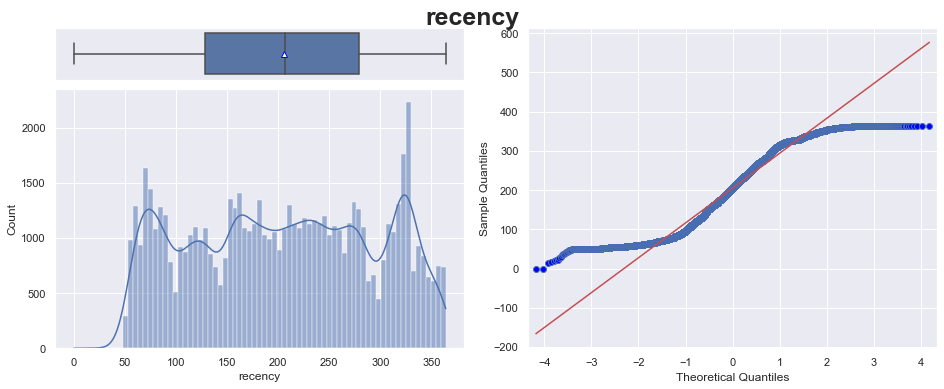


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,recency,Shapiro-Wilk,"Statistics=0.956, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,recency,D’Agostino’s K^2,"Statistics=47257.880, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,recency,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


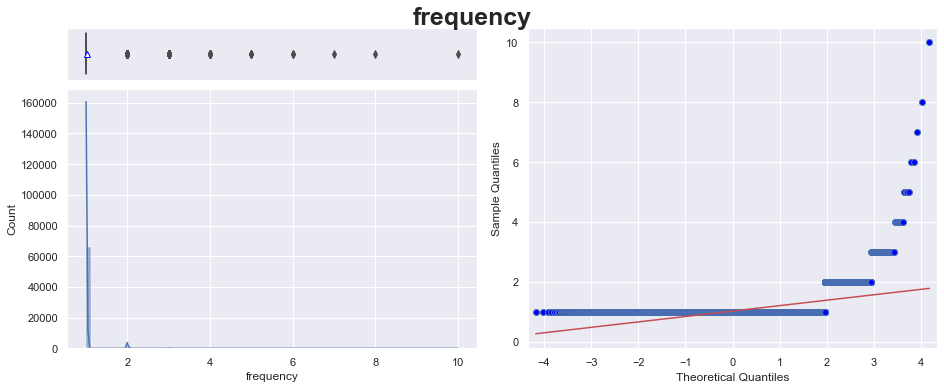


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,frequency,Shapiro-Wilk,"Statistics=0.128, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,frequency,D’Agostino’s K^2,"Statistics=108241.927, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,frequency,Kolmogorov-Smirnov,"Statistics=0.841, p-value=0.000",Sample does not look Gaussian (reject H₀)


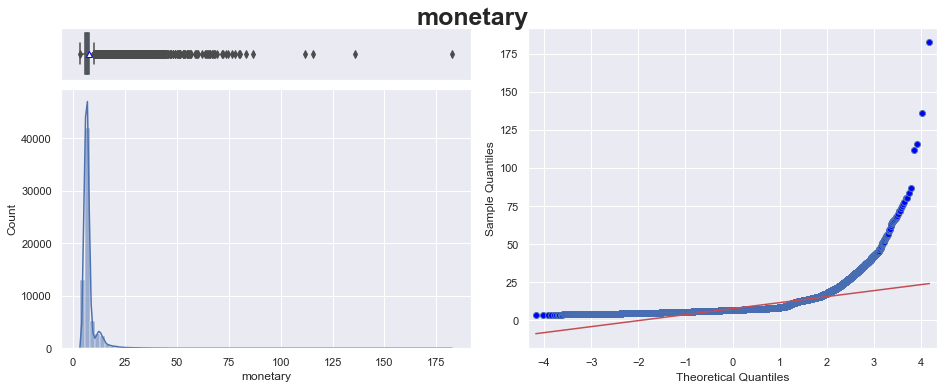


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,monetary,Shapiro-Wilk,"Statistics=0.520, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,monetary,D’Agostino’s K^2,"Statistics=91282.484, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,monetary,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


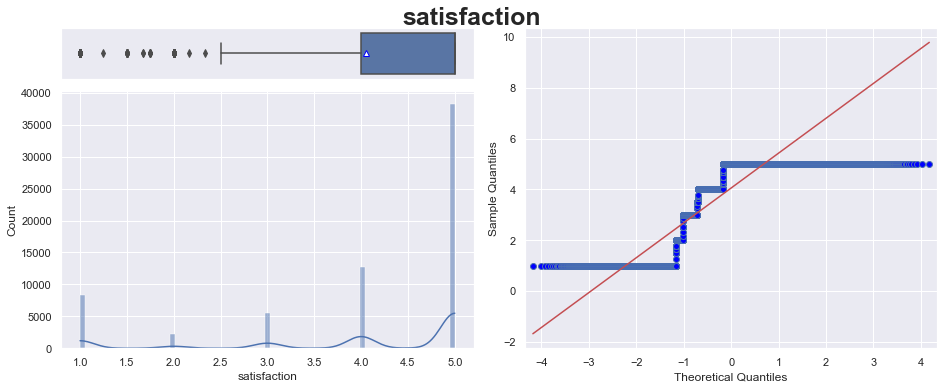


Making the Normality Test
---------------------------------


C:\Users\Samir\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,variable,normality test,result,hypothesis
0,satisfaction,Shapiro-Wilk,"Statistics=0.698, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,satisfaction,D’Agostino’s K^2,"Statistics=11887.129, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,satisfaction,Kolmogorov-Smirnov,"Statistics=0.854, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [344]:
for var in df_RFM.columns:
    
    if var != "customer_unique_id":
        
        fig = plt.figure(constrained_layout=True, figsize=[13,5])
        fig.suptitle(var, size=25, fontweight="bold", y=1.05)
        spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])
        
        ax_box = fig.add_subplot(spec[0, 0])
        ax_hist = fig.add_subplot(spec[1, 0])
        ax_qqplot = fig.add_subplot(spec[:, 1])
        
        # Boxplot
        boxplot = sns.boxplot(data=df_RFM, x=df_RFM[var], showmeans=True, ax=ax_box,
                          meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        
        ax_box.set(xlabel="", xticks=[])
        ax_box.set(yticks=[])
        boxplot.set_title("")
        
        # Histplot
        sns.histplot(data=df_RFM, x=df_RFM[var], bins=75,  kde=True,  ax=ax_hist)
        ax_hist.set(xlabel=var)
    
        # QQplot
        qqplot(df_RFM[var], line='s', ax=ax_qqplot)

        plt.savefig("images/qqplot-of-" + var + ".png")
        plt.show()

        print("\nMaking the Normality Test")
        print("---------------------------------")
        normality_test(df_RFM[[var]])
        print("\n")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>There is not a normal distribution among the features</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.2. Bivariate analysis</h3>
</div>

In [347]:
RFM_frequency = {"monetary" : "green", "recency" : "blue", "satisfaction" : "red"}

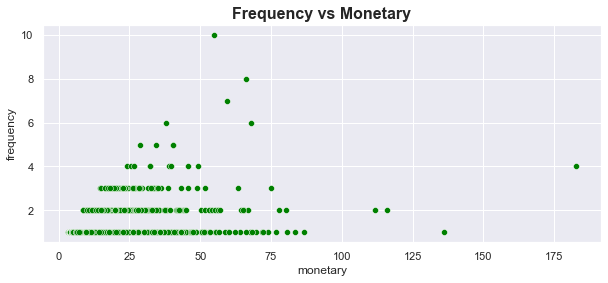

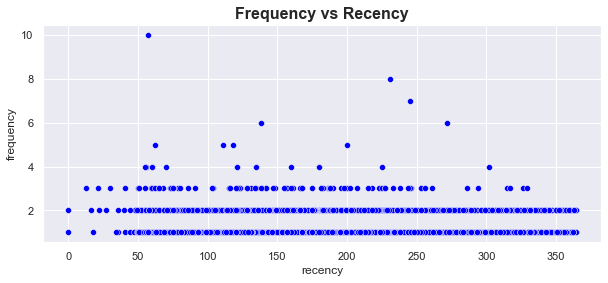

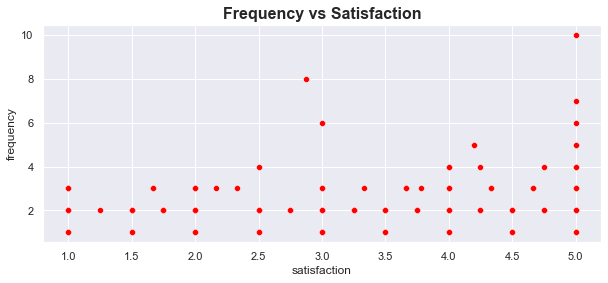

In [348]:
for col in RFM_frequency.keys():
    plt.figure(figsize=(10, 4))
    sns.scatterplot(data=df_RFM, 
                    x=df_RFM.groupby("customer_unique_id")[col].sum(), 
                    y=df_RFM.groupby("customer_unique_id")["frequency"].sum(),
                    color=RFM_frequency.get(col))
    plt.title("Frequency vs " + col.capitalize(), size=16, fontweight="bold")
    plt.savefig("images/frequency-vs-" + col + ".png")
    sns.despine(fig)
    plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li><b>Frequency vs Monetary</b>: Regular purchases are for a small amount of money </li>
        <li><b>Frequency vs Recency</b>: The purchase frequency is low compared to recency </li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.3. RFM Score</h3>
</div>

In [349]:
df_RFM.head()

,customer_unique_id,recency,frequency,monetary,satisfaction
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,7.158862,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,4.817112,4.0
2,0004aac84e0df4da2b147fca70cf8255,336,1,7.628555,5.0
3,0004bd2a26a76fe21f786e4fbd80607f,194,1,7.392146,4.0
4,00050ab1314c0e55a6ca13cf7181fecf,180,1,5.185074,4.0


In [350]:
quantiles = df_RFM[["recency", "frequency", "monetary"]].quantile([.2, .4, .6, .8])
quantiles

,recency,frequency,monetary
0.2,113.0,1.0,5.831371
0.4,176.0,1.0,6.520045
0.6,235.0,1.0,7.161283
0.8,300.0,1.0,8.060155


In [351]:
df_RFM["r_score"] = df_RFM["recency"].apply(lambda X: quintile_score(X, quantiles, "recency"))
df_RFM["f_score"] = df_RFM["frequency"].apply(lambda X: quintile_score(X, quantiles, "frequency"))
df_RFM["m_score"] = df_RFM["monetary"].apply(lambda X: quintile_score(X, quantiles, "monetary"))
df_RFM["rfm_score"] = df_RFM[["r_score", "f_score", "m_score"]].sum(axis=1)

In [352]:
df_RFM.head()

,customer_unique_id,recency,frequency,monetary,satisfaction,r_score,f_score,m_score,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,7.158862,5.0,2,1,3,6
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,4.817112,4.0,2,1,1,4
2,0004aac84e0df4da2b147fca70cf8255,336,1,7.628555,5.0,5,1,4,10
3,0004bd2a26a76fe21f786e4fbd80607f,194,1,7.392146,4.0,3,1,4,8
4,00050ab1314c0e55a6ca13cf7181fecf,180,1,5.185074,4.0,3,1,1,5


In [353]:
df_RFM["rfm_score"].max()

15

<div class="alert alert-block alert-info">
    <p>Let's create some human friendly labels for the scores based on the max score as 15</p>
    <ul style="list-style-type: disc;">
        <li><b>Bronze</b>: 1-5 </li>
        <li><b>Silver</b>: 6-9 </li>
        <li><b>Gold</b>: 10-12  </li>
        <li><b>Platinum</b>: 13-15 </li>
    </ul> 
</div>

In [377]:
df_RFM["rfm_score_label"] = "Bronze"
df_RFM.loc[df_RFM["rfm_score"] >= 6, "rfm_score_label"] = "Silver"
df_RFM.loc[df_RFM["rfm_score"] >= 10, "rfm_score_label"] = "Gold"
df_RFM.loc[df_RFM["rfm_score"] >= 13, "rfm_score_label"] = "Platinum"

In [380]:
df_RFM.head()

,customer_unique_id,recency,frequency,monetary,satisfaction,r_score,f_score,m_score,rfm_score,rfm_score_label
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,7.158862,5.0,2,1,3,6,Silver
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,4.817112,4.0,2,1,1,4,Bronze
2,0004aac84e0df4da2b147fca70cf8255,336,1,7.628555,5.0,5,1,4,10,Gold
3,0004bd2a26a76fe21f786e4fbd80607f,194,1,7.392146,4.0,3,1,4,8,Silver
4,00050ab1314c0e55a6ca13cf7181fecf,180,1,5.185074,4.0,3,1,1,5,Bronze


<div class="alert alert-block alert-danger">
    <p>RFM Category based on concatenation of score</p>
    https://towardsdatascience.com/how-to-identify-the-best-customers-using-rfm-based-segmentation-a0a16c34a859

</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">9.4. RFM Segmentation</h3>
</div>

In [ ]:
new = df_RFM.loc[:]

In [ ]:
df_analysis(new, "new", type_analysis="complete")

In [ ]:
def RFM_segmentation_labels(rfm):

    if 4 <= rfm["r_score"] <= 5 and 4 <= rfm["f_score"] <= 5 and 4 <= rfm["m_score"] <= 5:
        return "Champions"

    elif 3 <= rfm["r_score"] <= 5 and 3 <= rfm["f_score"] <= 5 and 2 <= rfm["m_score"] <= 5:
        return "Loyal Customers"

    elif 3 <= rfm["r_score"] <= 5 and 1 <= rfm["f_score"] <= 3 and 1 <= rfm["m_score"] <= 3:
        return "Potential Loyalist"

    elif rfm["r_score"] >= 4 and rfm["f_score"] <= 2:
        return "Recent Customers"

    elif 3 <= rfm["r_score"] <= 4 and rfm["f_score"] <= 1 and rfm["m_score"] <= 1:
        return "Promising"

    elif 2 <= rfm["r_score"] <= 3 and 2 <= rfm["f_score"] <= 3 and 2 <= rfm["m_score"] <= 3:
        return "Need Attention"

    elif 2 <= rfm["r_score"] <= 3 and rfm["f_score"] <= 2 and rfm["m_score"] <= 2:
        return "About To Sleep"

    elif rfm["r_score"] <= 1 and 4 <= rfm["f_score"] <= 5 and 4 <= rfm["m_score"] <= 5:
        return "Can't Lose Them"

    elif rfm["r_score"] <= 2 and 2 <= rfm["f_score"] <= 5 and 2 <= rfm["m_score"] <= 5:
        return "At Risk"

    elif rfm["r_score"] <= 2 and rfm["f_score"] <= 2 and rfm["m_score"] <= 2:
        return "Lost"

    else:
        return "Others"

In [ ]:
new["rfm_segmentation"] = new.apply(RFM_segmentation_labels, axis=1)

In [ ]:
new.head()

In [ ]:
df_analysis(new, "new", type_analysis="complete")

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [ ]:
raise SystemExit("Stop right there!")

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [175]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div style="background-color: #6D83C5;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">Customer with more than 1 order</h2>
</div>

In [178]:
df_imputed[df_imputed["customer_unique_id"] == "001147e649a7b1afd577e873841632dd"]

,order_id,customer_unique_id,order_purchase_timestamp,order_status,review_score,payment_value,product_category,product_weight_g,customer_city,customer_state,customer_region,purchase_year,purchase_month,purchase_weekday,purchase_day,purchase_hour,product_volume_cc
74481,533dbcda0a703be171113573af8b3467,001147e649a7b1afd577e873841632dd,2017-08-31 17:12:56,delivered,4.0,6.742545,housewares,11.598518,maringa,PR,South,2017,8,3,31,17,127.589603
74482,533dbcda0a703be171113573af8b3467,001147e649a7b1afd577e873841632dd,2017-08-31 17:12:56,delivered,4.0,6.742545,housewares,11.598518,maringa,PR,South,2017,8,3,31,17,127.589603


In [186]:
df = pd.DataFrame(df_imputed.groupby(["customer_unique_id", "order_purchase_timestamp"]).size()).reset_index()

In [189]:
df[df[0]>1]

,customer_unique_id,order_purchase_timestamp,0
7,00053a61a98854899e70ed204dd4bafe,2018-02-28 11:15:41,2
18,000de6019bb59f34c099a907c151d855,2017-08-17 19:10:33,2
22,000fbf0473c10fc1ab6f8d2d286ce20c,2018-07-26 09:43:52,4
25,001147e649a7b1afd577e873841632dd,2017-08-31 17:12:56,2
32,0015752e079902b12cd00b9b7596276b,2018-08-02 18:23:51,2
...,...,...,...
99116,ffe96201d466b0e0dc8139850be29d5d,2018-07-16 16:35:30,2
99132,fff22793223fe80c97a8fd02ac5c6295,2018-06-26 11:01:47,3
99136,fff5eb4918b2bf4b2da476788d42051c,2018-07-02 16:39:59,6
99138,fff7219c86179ca6441b8f37823ba3d3,2017-12-27 18:57:38,2


In [192]:
mask = df.duplicated("customer_unique_id", keep=False)

In [193]:
df["duplicated"] = mask

In [194]:
df[df["duplicated"]==True]

,customer_unique_id,order_purchase_timestamp,0,duplicated
33,00172711b30d52eea8b313a7f2cced02,2018-07-28 00:23:49,1,True
34,00172711b30d52eea8b313a7f2cced02,2018-08-13 09:14:07,1,True
107,004288347e5e88a27ded2bb23747066c,2017-07-27 14:13:03,1,True
108,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,1,True
126,004b45ec5c64187465168251cd1c9c2f,2017-09-01 12:11:23,1,True
...,...,...,...,...
98966,ff8892f7c26aa0446da53d01b18df463,2017-05-24 16:09:14,1,True
98967,ff8892f7c26aa0446da53d01b18df463,2017-11-26 23:25:43,1,True
98985,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-02-22 12:26:42,1,True
98986,ff922bdd6bafcdf99cb90d7f39cea5b3,2017-08-23 13:15:29,1,True


In [195]:
df_imputed[df_imputed["customer_unique_id"]=="00172711b30d52eea8b313a7f2cced02"]

,order_id,customer_unique_id,order_purchase_timestamp,order_status,review_score,payment_value,product_category,product_weight_g,customer_city,customer_state,customer_region,purchase_year,purchase_month,purchase_weekday,purchase_day,purchase_hour,product_volume_cc
45288,c306eca42d32507b970739b5b6a5a33a,00172711b30d52eea8b313a7f2cced02,2018-08-13 09:14:07,canceled,4.0,7.656878,unknown,10.383658,jequie,BA,Northeast,2018,8,0,13,9,106.683635
79683,bb874c45df1a3c97842d52f31efee99a,00172711b30d52eea8b313a7f2cced02,2018-07-28 00:23:49,delivered,4.0,6.943335,stationery,12.609871,jequie,BA,Northeast,2018,7,5,28,0,125.327323


In [ ]:
df_weight_details_payments_by_customer

In [196]:
df_weight_details_payments_by_customer[df_weight_details_payments_by_customer["customer_unique_id"]=="00172711b30d52eea8b313a7f2cced02"]

,customer_unique_id,auto,bed_bath_table,computers_accessories,furniture_decor,garden_tools,health_beauty,housewares,sports_leisure,toys,watches_gifts,total_payments_value
33,00172711b30d52eea8b313a7f2cced02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.600214


<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [175]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to reduce the numbers of categories</p>
</div>

In [ ]:
product_categories = {
    
    "unknown" : "unknown",
    
    "fashion_bags_accessories": "fashion",    
    "fashio_female_clothing": "fashion",
    "fashion_sport": "fashion",
    "fashion_shoes": "fashion",
    "fashion_male_clothing": "fashion",   
    "fashion_underwear_beach": "fashion",
    "fashion_childrens_clothes": "fashion",
    "cool_stuff": "fashion",
    "art": "fashion",
    "arts_and_craftmanship": "fashion",
    
    
    "kitchen_dining_laundry_garden_furniture": "furniture",
    "furniture_decor": "furniture",
    "office_furniture": "furniture",
    "furniture_bedroom": "furniture",
    "furniture_living_room": "furniture",
    "furniture_mattress_and_upholstery": "furniture",
    "bed_bath_table": "furniture",

    
    "home_appliances": "home",
    "home_appliances_2": "home",
    "home_confort": "home",
    "home_comfort_2": "home",
    "air_conditioning": "home",
    "housewares": "home",
    "flowers": "home",
    
    
    "electronics": "electronics",
    "audio": "electronics",
    "tablets_printing_image": "electronics",
    "telephony": "electronics",
    "fixed_telephony": "electronics",
    "small_appliances": "electronics",
    "small_appliances_home_oven_and_coffee": "electronics",
    "computers_accessories": "electronics",
    "computers": "electronics",
    "pc_gamer": "electronics",
    "consoles_games": "electronics",
    "dvds_blu_ray": "electronics",
    
    
    "construction_tools_construction": "construction",
    "construction_tools_lights": "construction",
    "construction_tools_safety": "construction",
    "costruction_tools_garden": "construction",
    "costruction_tools_tools": "construction",
    "garden_tools": "construction",
    "home_construction": "construction",

    
    "sports_leisure": "sports_leisure",
    "musical_instruments": "sports_leisure",
    "toys": "sports_leisure",
    "cine_photo": "sports_leisure",

    "cds_dvds_musicals": "sports_leisure",
    "music": "sports_leisure",
    "books_general_interest": "sports_leisure",
    "books_imported": "sports_leisure",
    "books_technical": "sports_leisure",

    
    "drinks": "food_drink",
    "food": "food_drink",
    "food_drink": "food_drink",
    "la_cuisine": "food_drink",
    "portateis_cozinha_e_preparadores_de_alimentos": "food_drink",

    
    "signaling_and_security": "misc",
    "watches_gifts": "misc",
    "agro_industry_and_commerce": "misc",
    "security_and_services": "misc",
    "market_place": "misc",
    "pet_shop": "misc",    
    "industry_commerce_and_business": "misc",  
    
    
    "health_beauty": "health_beauty",
    "perfumery": "health_beauty",
    "diapers_and_hygiene": "health_beauty",
    "baby": "health_beauty",

    
    "christmas_supplies": "supplies",
    "stationery": "supplies",
    "party_supplies": "supplies",
    "auto": "supplies",
    "luggage_accessories": "supplies"
}

In [ ]:
df_imputed["product_category"] = df_imputed["product_category"].replace(product_categories)

In [ ]:
df_analysis(df_imputed, "df_imputed", type_analysis="complete")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">8.3.1. From product categories to features</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to <b>transform the products categories to features</b> based on their <b>importance and/or weight in payments value</b> for each customer</p>
    <p>First of all, let's try to identify whether we can discard some categories with a few payments value in relation with the others categories</p>
</div>

In [ ]:
df_total_payments_value_by_category = df_imputed.groupby(["product_category"]).agg({
                                "payment_value": "sum"
                                }).sort_values("payment_value", ascending=False).reset_index()
df_total_payments_value_by_category

<div class="alert alert-block alert-warning">
    <p>Remember, we have <b>transformed to log</b> the feature <b>payment_value</b>, due to that, it doesn't seem coherence</p>
</div>

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(y="product_category", x="payment_value", data=df_total_payments_value_by_category)
plt.title("Total payments value by catgegory", size=20)
plot.set(xlabel="Occurence number", ylabel="Words")
plt.savefig("images/total-payments-values-by-category.png")
sns.despine(fig)
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>We get that <b>unknow</b> and <b>food_drinks</b> are the less important so, we can discard them</p>
</div>

<div class="alert alert-block alert-info">
    <p>Now, let's identify <b>the total payments values by customer</b></p>
</div>

In [ ]:
df_total_payments_value_by_customer = df_imputed.groupby(["customer_unique_id"]).agg({
                                "payment_value": "sum"
                                }).sort_values("payment_value", ascending=False).reset_index()
df_total_payments_value_by_customer.head(10)

df_total_payments_value_by_customer.rename(columns={"payment_value":"total_payments_value"}, inplace=True)

df_total_payments_value_by_customer

<div class="alert alert-block alert-info">
    <p>Now, let's identify <b>the payments values by customer by categories</b></p>
</div>

In [ ]:
df_payments_value_by_customer_by_category = df_imputed.groupby(["customer_unique_id", "product_category"]).agg({
                                            "payment_value": "sum"
                                            }).sort_values("payment_value", ascending=False).sort_values("customer_unique_id", ascending=True).reset_index()
df_payments_value_by_customer_by_category.head(10)

In [ ]:
df_temp = df_payments_value_by_customer_by_category.loc[:]

In [ ]:
mask = df_temp.duplicated("customer_unique_id")

In [ ]:
df_temp["duplicated"] = mask

In [ ]:
df_temp[df_temp["duplicated"] == True]

<div class="alert alert-block alert-info">
    <p>Now, let's pivot the table</p>
</div>

In [ ]:
df_payments_value_by_customer_by_category = pd.pivot_table(df_payments_value_by_customer_by_category, values="payment_value", index=["customer_unique_id"], columns=["product_category"])
df_payments_value_by_customer_by_category.reset_index(inplace=True)
df_payments_value_by_customer_by_category.columns.name = None
df_payments_value_by_customer_by_category

In [ ]:
df_analysis(df_payments_value_by_customer_by_category, "df_total_value_by_customer_by_category", type_analysis="complete")

<div class="alert alert-block alert-warning">
    <p>We can see a lot of missing-values. Let's fill them with 0</p>
</div>

In [ ]:
df_payments_value_by_customer_by_category.fillna(0, inplace=True)
df_payments_value_by_customer_by_category

<div class="alert alert-block alert-info">
    <p>Let's concatenate the two datasets</p>
</div>

In [ ]:
df_details_payments_by_customer = df_payments_value_by_customer_by_category.merge(right=df_total_payments_value_by_customer, on="customer_unique_id", how="left")

In [ ]:
df_details_payments_by_customer.head()

<div class="alert alert-block alert-info">
    <p>At this point, we can delete the features that are not interesting due to their low value</p>
</div>

In [ ]:
df_details_payments_by_customer.drop(columns=["unknown", "food_drink"], axis=1, inplace=True)

In [ ]:
df_details_payments_by_customer.head()

<div class="alert alert-block alert-info">
    <p>Now, let's calculate the weight of each category with respect to total_payments_values</p>
</div>

In [ ]:
df_analysis(df_details_payments_by_customer, "df_details_payments_by_customer", type_analysis="complete")

In [ ]:
df_details_payments_by_customer

In [ ]:
df_temp = df_details_payments_by_customer.loc[:]

In [ ]:
for col in df_temp.columns:
     if col != "total_payments_value" and col != "customer_unique_id":
            df_temp[col] = df_temp[col] / df_temp["total_payments_value"] * 100

In [ ]:
df_temp

In [ ]:
df_analysis(df_temp, "df_temp
            ", type_analysis="complete")

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [ ]:
raise SystemExit("Stop right there!")

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

In [ ]:
for col in df_details_payments_by_customer.columns:
    if col != "total_payments_value" and col != "customer_unique_id":
        df_details_payments_by_customer[col] = df_details_payments_by_customer[col] / df_details_payments_by_customer["total_payments_value"]

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [ ]:
raise SystemExit("Stop right there!")

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

In [ ]:
df_analysis(df_imputed, "df_imputed", type_analysis="complete")

In [ ]:
df_imputed.groupby(["customer_unique_id"]).agg({
    "payment_value": "sum"
}).sort_values("payment_value", ascending=False)

In [ ]:
df_example[df_example["customer_unique_id"]=="3e43e6105506432c953e165fb2acf44c"]

In [ ]:
mask = df_example["customer_unique_id"].duplicated(keep=False)

In [ ]:
df_example["duplicated"] = mask

In [ ]:
df_example[df_example["duplicated"]==True].sort_values(["payment_value", "customer_unique_id"], ascending=False).head()

In [ ]:
df_imputed[df_imputed["customer_unique_id"]=="3e43e6105506432c953e165fb2acf44c"]["payment_value"].sum()

In [ ]:
df_imputed.head()

In [ ]:
rfm_custom = data.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "mean"
})

Khalil FAIZ12:33 PM <br>
Client <br>
Pays <br>
Ville<br>
Average rate per user (satisfaction)<br>
Fréquence : countd(order_id) Where (filtre sur 6 mois par exemple)<br>
Panier moyen : Sum(net_amount) / countd(order_id) Where (filtre sur 6 mois par exemple)<br>

https://www.definitions-marketing.com/definition/segmentation-rfm/<br>
https://lms.simplilearn.com/courses/4414/Introduction-to-Supervised-&-Unsupervised-Machine-Learning/syllabus<br>

https://classroom.udacity.com/courses/st101<br>
https://classroom.udacity.com/courses/ud827<br>
https://www.freecodecamp.org/news/free-machine-learning-course-10-hourse/<br>

https://towardsdatascience.com/10-highly-probable-data-scientist-interview-questions-fd83f7414760<br>